## Outline {-}

- [Task 1](#task-1): Neural networks
  - [1.1](#q11) Multi-layer perceptron
  - [1.2](#q12) Convolutional neural network (CNN)
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
  - [2.2](#q22) Clustering of the feature matrix
  - [2.3](#q23) Graph-based analysis 

Importing relevant packages:

In [5]:
import numpy as np
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import linalg

In [6]:
plt.style.use('fivethirtyeight')

# Task 1: Neural networks {-}

## 1.1 Multi-layer perceptron {-}

Importing the Fashion-MNIST data set:

In [7]:
def load_data():
    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

    return ((x_train, y_train), (x_test, y_test))

In [8]:
(x_train, y_train), (x_test, y_test) = load_data()

The data set (split into a size $60000$ training set and a size $10000$ test set) consists of images belonging to $10$ classes of items sold by a fashion online store (e.g. t-shirt, pullover, dress etc.). The images are in a $28 \times 28 \times 1$ pixles format (the third dimension indicates that the images are in a grayscale format and not in an RGB format). The data set (both the training and the test set) are well balanced i.e. the $10$ classes are uniformly distributed.

Looking at a few examples in the training data set:

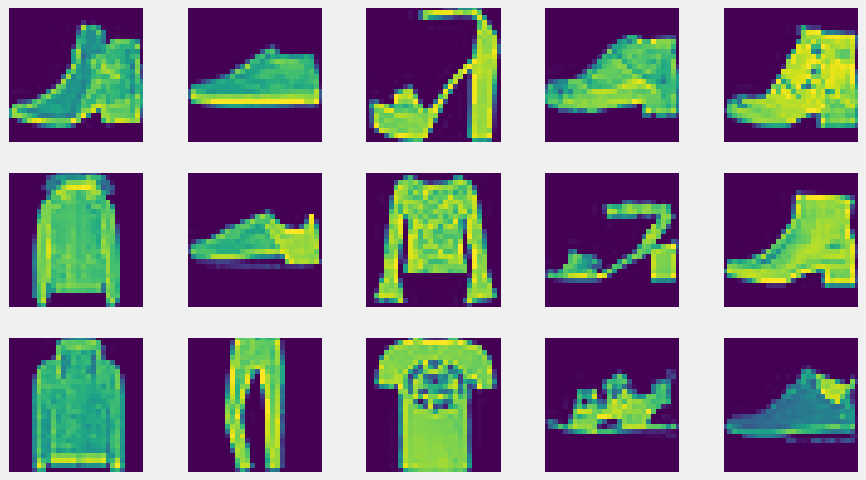

In [5]:
n_rows, n_cols = 3, 5
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

We will now build an MLP (multi-layer perceptron) model to perform a classification task on the Fashion-MNIST data set. The architecture of the MLP is: one input layer (a batch of $28 \times 28$ images passed as an input), five hidden (fully connected) layers with $400$ neurons each and one output layer with $10$ neurons (one for each class). The activation function between the hidden layers will be the _LeakyReLU_ function (with a negative slope of $0.01$) and the activation function for the output layer will be the _softmax_ function. We will first reshape the data (flatten the images and transpose the design matrices):

In [6]:
x_train = x_train.reshape(60000, 784).T
y_train = y_train.T
x_test = x_test.reshape(10000, 784).T
y_test = y_test.T

We first need to initialise the parameters of the neural network.
    
Going from the input layer to the first hidden layer: $\mathbf{W}^{(0)} \in \mathbb{R}^{400 \times 784}$ and $\mathbf{b}^{(0)} \in \mathbb{R}^{400}$;  
Going from one hidden layer to the next one: $\mathbf{W}^{(k)} \in \mathbb{R}^{400 \times 400}$ and $\mathbf{b}^{(k)} \in \mathbb{R}^{400}$ for $k = 1, 2, 3, 4$;  
Going from the last hidden layer to the output layer: $\mathbf{W}^{(5)} \in \mathbb{R}^{10 \times 400}$ and $\mathbf{b}^{(5)} \in \mathbb{R}^{10}$.

We will initialise the parameters using the Glorot strategy: the kernel values will be initalised with samples from a zero-mean Gaussian distribution with variance $2/(n_{in} + n_{out})$ (where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layers respectively) and the bias values will be initialised with zeros. There are a total of $959610$ parameters in this neural network.

In [7]:
def init_params():
    var0 = 2. / (784 + 400)
    W0 = np.random.randn(400, 784) * np.sqrt(var0)
    b0 = np.zeros((400, 1))
    
    var1 = 2. / (400 + 400)
    W1 = np.random.randn(400, 400) * np.sqrt(var1)
    b1 = np.zeros((400, 1))
    
    var2 = 2. / (400 + 400)
    W2 = np.random.randn(400, 400) * np.sqrt(var2)
    b2 = np.zeros((400, 1))
    
    var3 = 2. / (400 + 400)
    W3 = np.random.randn(400, 400) * np.sqrt(var3)
    b3 = np.zeros((400, 1))
    
    var4 = 2. / (400 + 400)
    W4 = np.random.randn(400, 400) * np.sqrt(var4)
    b4 = np.zeros((400, 1))
    
    var5 = 2. / (400 + 10)
    W5 = np.random.randn(10, 400) * np.sqrt(var5)
    b5 = np.zeros((10, 1))
    
    return W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

The backpropagation algorithm is outlined in the lecture notes:

1. Propagate the signal forwards by passing an input vector $x_i$ through the network and compute the pre-activations $\mathbf{a}^{(k)} = \mathbf{W}^{(k)}\mathbf{h}^{(k)} + \mathbf{b}^{(k)}$ and post-activations $\mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)})$ for all layers $k = 1, ..., 6$;
2. Evaluate $\delta^{(6)} = \frac{\partial{L_i}}{\partial{\mathbf{a}^{(6)}}}$ for the output neurons;
3. Backpropagate the errors to compute $\delta^{(k)} = \sigma'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T\delta^{(k+1)}$ for each hidden layer $k = 1, ..., 5$;
4. Obtain the derivatives of $L_i$ with respect to the weights and biases as $\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}} = \delta_p^{(k+1)}h_q^{(k)}$ and $\frac{\partial{L_i}}{\partial{b_p^{(k)}}} = \delta_p^{(k+1)}$.

In practice, we will pass a _batch_ of input vectors through the network and define the batch loss as the average of the individual losses in that batch. We will use the categorical cross-entropy as the individual loss function. We will first implement the forward pass (step $1$ of the algorithm):

In [8]:
# element-wise LeakyReLU function
def LeakyReLU(x, negative_slope=0.01):
    if x > 0:
        return x
    else:
        return negative_slope * x

# vectorized LeakyReLU function
LeakyReLUv = np.vectorize(LeakyReLU)

# softmax function for the output layer
def softmax(A):
    return np.exp(A) / np.sum(np.exp(A), axis=0)

def forward_pass(W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, X):
    
    # propagate the input signal(s) X according to formula above
    # hidden layer 1
    A1 = W0.dot(X) + b0
    H1 = LeakyReLUv(A1)

    # hidden layer 2
    A2 = W1.dot(H1) + b1
    H2 = LeakyReLUv(A2)

    # hidden layer 3
    A3 = W2.dot(H2) + b2
    H3 = LeakyReLUv(A3)

    # hidden layer 4
    A4 = W3.dot(H3) + b3
    H4 = LeakyReLUv(A4)

    # hidden layer 5
    A5 = W4.dot(H4) + b4
    H5 = LeakyReLUv(A5)

    # output layer
    A6 = W5.dot(H5) + b5
    Y_out = softmax(A6)
    
    return A1, H1, A2, H2, A3, H3, A4, H4, A5, H5, A6, Y_out

We will now implement the backward pass and computation of the partial derivatives (steps $2$ through $4$). For step $2$, we note that the error for the output layer can be computed as
$$ \delta^{(6)} = \mathbf{Y} - \hat{\mathbf{Y}}_{out} $$

for the _softmax_ activation function and the categorical cross-entropy loss function as seen in this [video](https://www.youtube.com/watch?v=5-rVLSc2XdE).

In [9]:
# element-wise derivative of LeakyReLU function
def deriv_LeakyReLU(x, negative_slope=0.01):
    if x > 0:
        return 1
    else:
        return negative_slope

# vectorized derivative of LeakyReLU function
deriv_LeakyReLUv = np.vectorize(deriv_LeakyReLU)

def backward_pass(Y_out, Y, W5, H5, A5, W4, H4, A4, W3, H3, A3, W2, H2, A2, W1, H1, A1, X):
    
    # number of images in batch
    m = Y.shape[1]

    # compute error for output layer using formula from above
    delta6 = Y_out - Y
    # compute partial derivatives
    dW5 = (1 / m) * delta6.dot(H5.T)
    db5 = (1 / m) * np.sum(delta6, axis=1)
    
    # hidden layer 5
    delta5 = W5.T.dot(delta6) * deriv_LeakyReLUv(A5)
    dW4 = (1 / m) * delta5.dot(H4.T)
    db4 = (1 / m) * np.sum(delta5, axis=1)
    
    # hidden layer 4
    delta4 = W4.T.dot(delta5) * deriv_LeakyReLUv(A4)
    dW3 = (1 / m) * delta4.dot(H3.T)
    db3 = (1 / m) * np.sum(delta4, axis=1)

    # hidden layer 3
    delta3 = W3.T.dot(delta4) * deriv_LeakyReLUv(A3)
    dW2 = (1 / m) * delta3.dot(H2.T)
    db2 = (1 / m) * np.sum(delta3, axis=1)

    # hidden layer 2
    delta2 = W2.T.dot(delta3) * deriv_LeakyReLUv(A2)
    dW1 = (1 / m) * delta2.dot(H1.T)
    db1 = (1 / m) * np.sum(delta2, axis=1)

    # hidden layer 1
    delta1 = W1.T.dot(delta2) * deriv_LeakyReLUv(A1)
    dW0 = (1 / m) * delta1.dot(X.T)
    db0 = (1 / m) * np.sum(delta1, axis=1)
    
    return dW0, db0.reshape(-1, 1), dW1, db1.reshape(-1, 1), dW2, db2.reshape(-1, 1), \
           dW3, db3.reshape(-1, 1), dW4, db4.reshape(-1, 1), dW5, db5.reshape(-1, 1)

Lastly, having computed the partial derivatives of the loss function with respect to the weights and biases, we want to employ a stochastic gradient descent method to minimise $L$. The update procedure can be summarized as
$$\mathbf{W}^{(k)} = \mathbf{W}^{(k)} - \alpha \nabla_{\mathbf{W}^{(k)}} L$$
$$\mathbf{b}^{(k)} = \mathbf{b}^{(k)} - \alpha \nabla_{\mathbf{b}^{(k)}} L$$

for $k = 0, ..., 5$ where $\alpha > 0$ the learning rate.

In [10]:
def update_params(W0, b0, dW0, db0, W1, b1, dW1, db1, W2, b2, dW2, db2,
                  W3, b3, dW3, db3, W4, b4, dW4, db4, W5, b5, dW5, db5, alpha):

    W0 -= alpha * dW0
    b0 -= alpha * db0

    W1 -= alpha * dW1
    b1 -= alpha * db1

    W2 -= alpha * dW2
    b2 -= alpha * db2
    
    W3 -= alpha * dW3
    b3 -= alpha * db3
    
    W4 -= alpha * dW4
    b4 -= alpha * db4
    
    W5 -= alpha * dW5
    b5 -= alpha * db5
    
    return W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

During the training of the model (using the SGD method), we want to keep track of how the accuracy and loss function change for both the training data and the test data (we would hope that the former increases with the number of iterations, while the latter decreases). We implement these functions (minding the one-hot encoded form of the output):

In [11]:
def accuracy(pred, true):
    return np.mean(pred == true)

def loss(hat, true):
    
    N = hat.shape[1]
    l = np.zeros(N)
    
    # take log of model output
    log = np.log(hat)
    
    # iterate through all outputs
    for i in range(N):

        # compute the individual categorical cross-entropy
        l[i] = -np.dot(true[:, i], log[:, i])
    
    # compute the overall as the average of the individual losses
    return np.mean(l)

We want to iterate through the $60000$ samples in the training set multiple times (for a number of epochs) in batches of $256$ images. For each epoch, we want to divide the training set in different _randomized_ batches (the _stochastic_ aspect of SGD):

In [12]:
def get_batch_indices(N, batch_size):

    # compute number of batches
    n_batches = N // batch_size
    
    # permute images
    ind_perm = np.random.permutation(np.arange(N))
    
    batches = []
    
    for k in range(n_batches):

        # store indices corresponding to each batch
        batches.append(ind_perm[k*batch_size:(k+1)*batch_size])
        
    return batches

Finally, we can implement the SGD algorithm to optimize the parameters of the MLP:

In [13]:
def sgd(x_train, y_train, x_test, y_test, batch_size, n_epochs, alpha, print_progress=True):

    # initialise parameters
    W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = init_params()
    
    N = x_train.shape[1]
    
    # compute number of batches per epoch
    n_batches = N // batch_size
    
    acc_train_vec = np.zeros(n_epochs)
    loss_train_vec = np.zeros(n_epochs)

    acc_test_vec = np.zeros(n_epochs)
    loss_test_vec = np.zeros(n_epochs)
    
    # for each epoch...
    for i in range(n_epochs):
        
        #... get batch indices for this epoch
        batches = get_batch_indices(N, batch_size=batch_size)
        
        #... perform SGD
        for j in range(n_batches):
            
            # get current batch (pixel values and labels)
            X = x_train[:, batches[j]]
            Y = y_train[:, batches[j]]

            # perform forward pass
            A1, H1, A2, H2, A3, H3, A4, H4, A5, H5, A6, Y_out = forward_pass(W0, b0, W1, b1, W2, b2, \
                                                                             W3, b3, W4, b4, W5, b5, X)

            # perform backward pass
            dW0, db0, dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = backward_pass(Y_out, Y, W5, H5, A5, W4, H4, A4, \
                                                                                       W3, H3, A3, W2, H2, A2, W1, H1, A1, X)

            # update parameters
            W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = update_params(W0, b0, dW0, db0, W1, b1, dW1, db1, \
                                                                           W2, b2, dW2, db2, W3, b3, dW3, db3, \
                                                                           W4, b4, dW4, db4, W5, b5, dW5, db5, alpha=alpha)
        
        # get train prediction with current parameters
        _, _, _, _, _, _, _, _, _, _, _, hat_train = forward_pass(W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, x_train)
        pred_train = np.argmax(hat_train, 0)
        true_train = np.argmax(y_train, 0)

        # compute train accuracy
        acc_train = accuracy(pred_train, true_train)
        acc_train_vec[i] = acc_train
        
        # compute train loss
        loss_train = loss(hat_train, y_train)
        loss_train_vec[i] = loss_train
        
        # get test prediction with current parameters
        _, _, _, _, _, _, _, _, _, _, _, hat_test = forward_pass(W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, x_test)
        pred_test = np.argmax(hat_test, 0)
        true_test = np.argmax(y_test, 0)
        
        # compute test accuracy
        acc_test = accuracy(pred_test, true_test)
        acc_test_vec[i] = acc_test
        
        # compute test loss
        loss_test = loss(hat_test, y_test)
        loss_test_vec[i] = loss_test
        
        if print_progress:
            print('==== Epoch {} ===='.format(i+1))
            print('Train set accuracy = {}; Train set loss = {}'.format(acc_train, loss_train))
            print('Test set accuracy = {}; Test set loss = {}'.format(acc_test, loss_test))
        
    params = (W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
        
    return params, acc_train_vec, loss_train_vec, acc_test_vec, loss_test_vec

### Training the model

We will now train the MLP for $40$ epochs with a learning rate $\alpha = 10^{-3}$:

In [14]:
params3, acc_train_vec3, loss_train_vec3, acc_test_vec3, loss_test_vec3 = sgd(x_train, y_train, x_test, y_test, 
                                                                              batch_size=256, n_epochs=40, alpha=1e-3)

==== Epoch 1 ====
Train set accuracy = 0.3619; Train set loss = 2.22722042450473
Test set accuracy = 0.3611; Test set loss = 2.2272585318870015
==== Epoch 2 ====
Train set accuracy = 0.46415; Train set loss = 2.1220056743647975
Test set accuracy = 0.4579; Test set loss = 2.1226480583891765
==== Epoch 3 ====
Train set accuracy = 0.5081166666666667; Train set loss = 1.978271767173217
Test set accuracy = 0.4999; Test set loss = 1.9798053785811114
==== Epoch 4 ====
Train set accuracy = 0.5430833333333334; Train set loss = 1.792074398717538
Test set accuracy = 0.5312; Test set loss = 1.7949613828210615
==== Epoch 5 ====
Train set accuracy = 0.6187833333333334; Train set loss = 1.586109704091824
Test set accuracy = 0.6101; Test set loss = 1.5904845344354683
==== Epoch 6 ====
Train set accuracy = 0.6404333333333333; Train set loss = 1.3923677466842155
Test set accuracy = 0.6286; Test set loss = 1.3981144092131432
==== Epoch 7 ====
Train set accuracy = 0.6602666666666667; Train set loss = 1.22

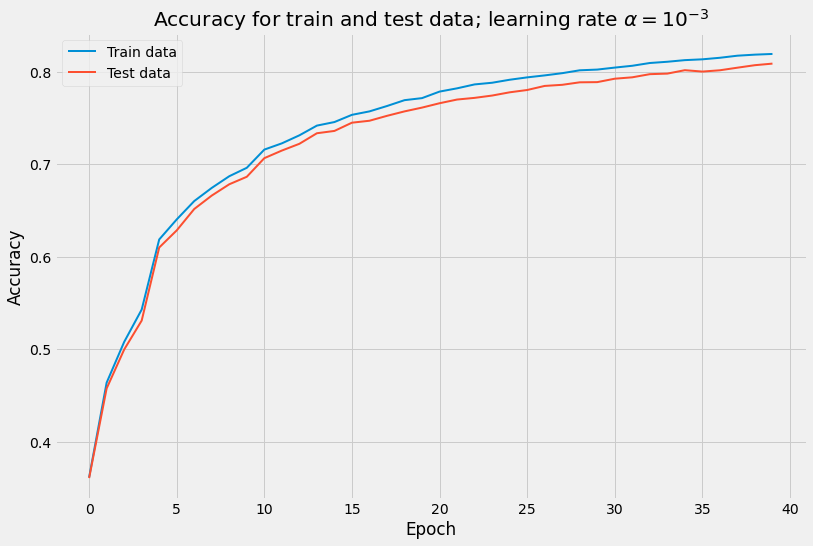

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(40), acc_train_vec3, linewidth=2, label='Train data')
plt.plot(np.arange(40), acc_test_vec3, linewidth=2, label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for train and test data; learning rate 'r'$\alpha=10^{-3}$')
plt.legend()
plt.show()

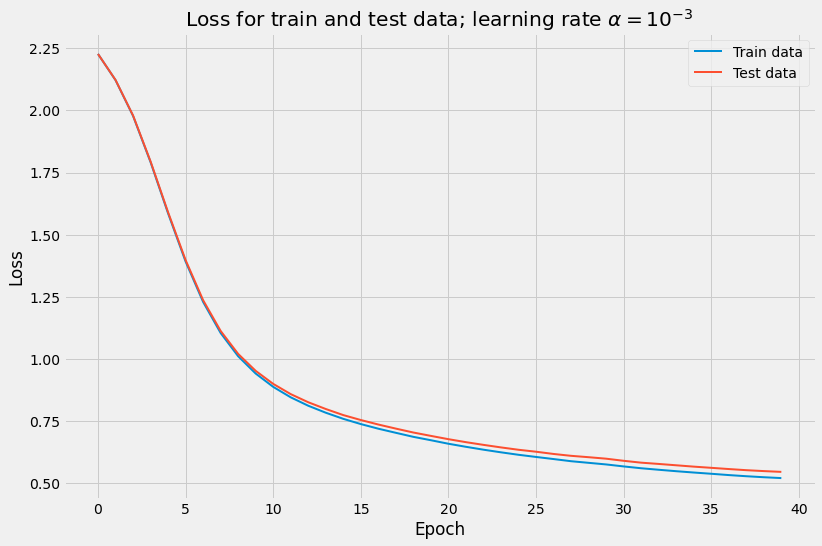

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(40), loss_train_vec3, linewidth=2, label='Train data')
plt.plot(np.arange(40), loss_test_vec3, linewidth=2, label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for train and test data; learning rate 'r'$\alpha=10^{-3}$')
plt.legend()
plt.show()

We can see that for this learning rate of $\alpha = 10^{-3}$, both curves (accuracy and loss over epochs) show a desirable behaviour: they are reasonably smooth (i.e. not noisy, no sudden jumps in either direction) denoting the robustness of the model. Another important thing to note is that both curves show very similar values for the training set and the test set (naturally, the accuracy for the test set is lower than the accuracy for the training set and vice versa for the loss but they are still comparable) denoting the generalisability of the model (i.e. this particular model is not overfirtting the train data). Lastly, we note that the accuracy of the model is not stellar (only around $82 \%$ for the train data and $81 \%$ for the test data) and, as we will see later, we might have reason to believe that the loss function is trapped in a local minima.

### Trying different learning rates

We will now train the MLP for $40$ epochs with a learning rate of $\alpha = 10^{-1}$:

In [17]:
params1, acc_train_vec1, loss_train_vec1, acc_test_vec1, loss_test_vec1 = sgd(x_train, y_train, x_test, y_test, 
                                                                              batch_size=256, n_epochs=40, alpha=1e-1,
                                                                              print_progress=False)

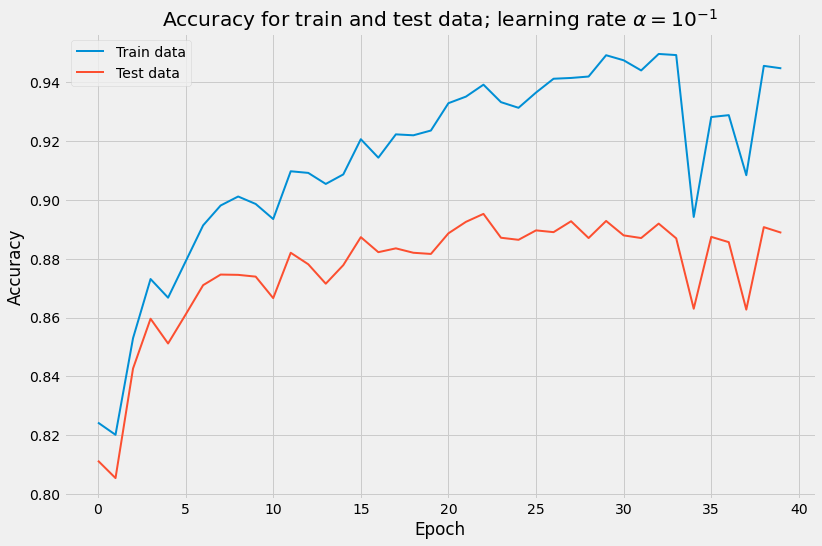

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(40), acc_train_vec1, linewidth=2, label='Train data')
plt.plot(np.arange(40), acc_test_vec1, linewidth=2, label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for train and test data; learning rate 'r'$\alpha=10^{-1}$')
plt.legend()
plt.show()

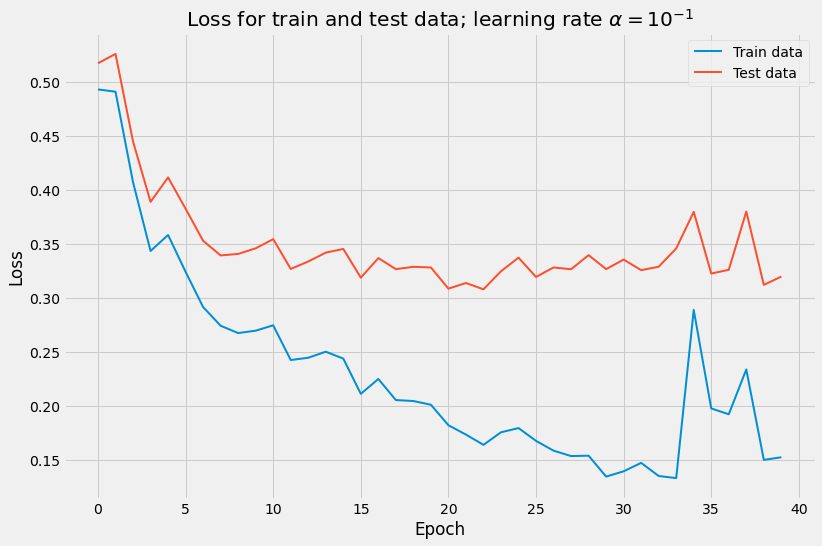

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(40), loss_train_vec1, linewidth=2, label='Train data')
plt.plot(np.arange(40), loss_test_vec1, linewidth=2, label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for train and test data; learning rate 'r'$\alpha=10^{-1}$')
plt.legend()
plt.show()

We will now train the MLP for $40$ epochs with a learning rate of $\alpha = 10^{-5}$:

In [20]:
params5, acc_train_vec5, loss_train_vec5, acc_test_vec5, loss_test_vec5 = sgd(x_train, y_train, x_test, y_test, 
                                                                              batch_size=256, n_epochs=40, alpha=1e-5,
                                                                              print_progress=False)

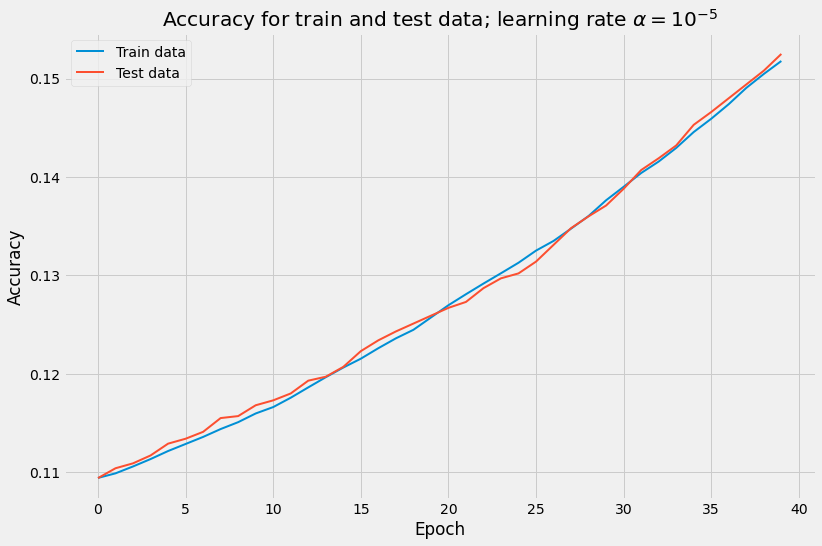

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(40), acc_train_vec5, linewidth=2, label='Train data')
plt.plot(np.arange(40), acc_test_vec5, linewidth=2, label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for train and test data; learning rate 'r'$\alpha=10^{-5}$')
plt.legend()
plt.show()

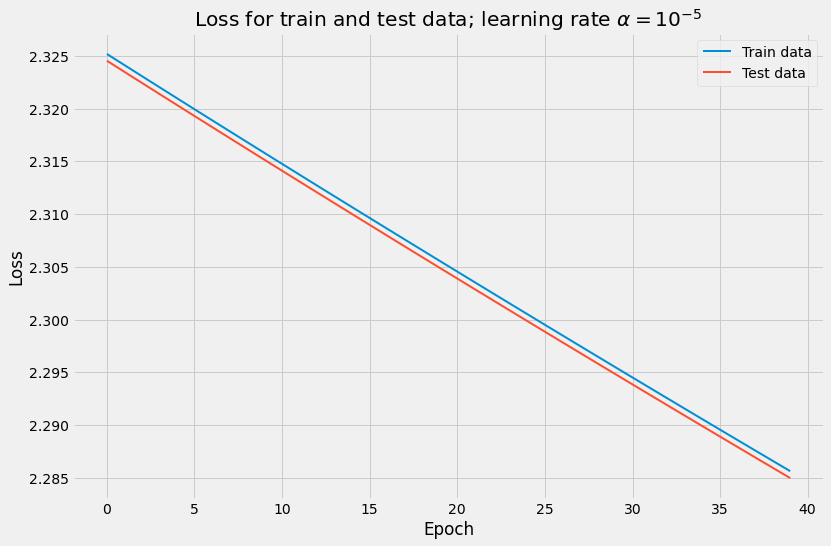

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(40), loss_train_vec5, linewidth=2, label='Train data')
plt.plot(np.arange(40), loss_test_vec5, linewidth=2, label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for train and test data; learning rate 'r'$\alpha=10^{-5}$')
plt.legend()
plt.show()

We can see that the two new learning rates considered show very different behaviour from $\alpha=10^{-3}$ (and also from one another).

For the learning rate of $\alpha = 10^{-1}$, we can immediately see that convergence is greatly accelerated (we note that $80 \%$ accuracy for the training set was reached after the first epoch, whereas previously approximatively $30$ epochs were needed to achieve this) and a much improved accuracy is attained ($94 \%$ accuracy for the training set at the end of the learning). However, the two curves are not nearly as smooth as before (i.e. the convergence is very noisy, the accuracy and loss jump up and down between epochs) suggesting that the learning rate we are using makes the SGD algorithm overshoot the optimal trajectory at times (progress is lost and is made up for in the next epoch). Another important thing to note is that, as opposed to what we've seen previously, while the accuracy and loss values are improving (noisly) over the epochs for the training set, they tend to stagnate (or even get worse) for the test set, suggesting that the model starts overfitting at some point. Hence, we can conclude that the advantages of using this learning rate come at the disadvantage of losing robustness and generalisability and thus, using this learning rate is not advisable.

For the learning rate of $\alpha = 10^{-5}$, the exact opposite behaviour is encountered: the two curves are _very_ smooth (especially for the training set), but almost no improvement can be seen across $40$ epochs of learning (both in terms of accuracy and loss; the former goes up from $10 \%$ to $15 \%$ while the latter goes down from $2.3$ to $2.8$). This suggests that the learning rate we are using makes the update of the parameters in the SGD algorithm almost non-existent (the parameter values change minimally from iteration to iteration and hence convergence is very slow). Hence, an unreasonably large number of epochs would be needed to reach meaningful results and thus, using this learning rate is not advisable.

### Training for more epochs

We will now train the MLP for $80$ epochs with a learning rate of $\alpha = 10^{-3}$:

In [24]:
params80, acc_train_vec80, loss_train_vec80, acc_test_vec80, loss_test_vec80 = sgd(x_train, y_train, x_test, y_test, 
                                                                                   batch_size=256, n_epochs=80, 
                                                                                   alpha=1e-3, print_progress=False)

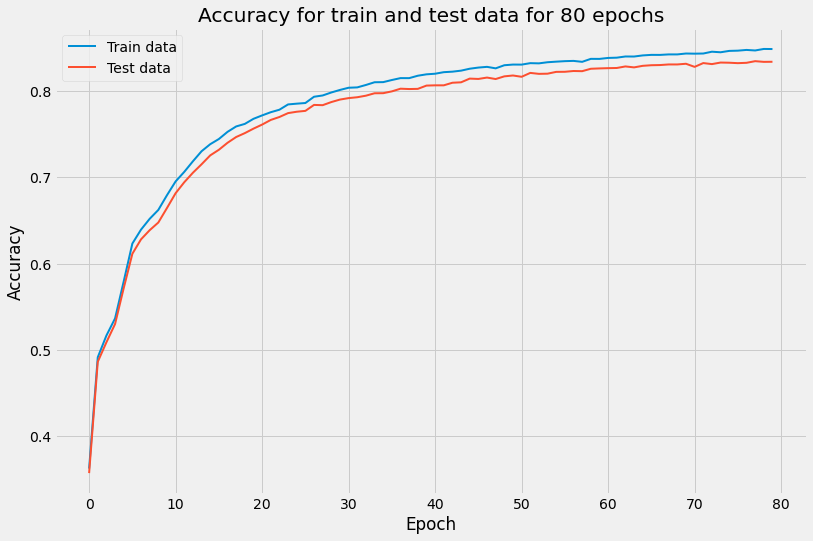

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(80), acc_train_vec80, linewidth=2, label='Train data')
plt.plot(np.arange(80), acc_test_vec80, linewidth=2, label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for train and test data for 80 epochs')
plt.legend()
plt.show()

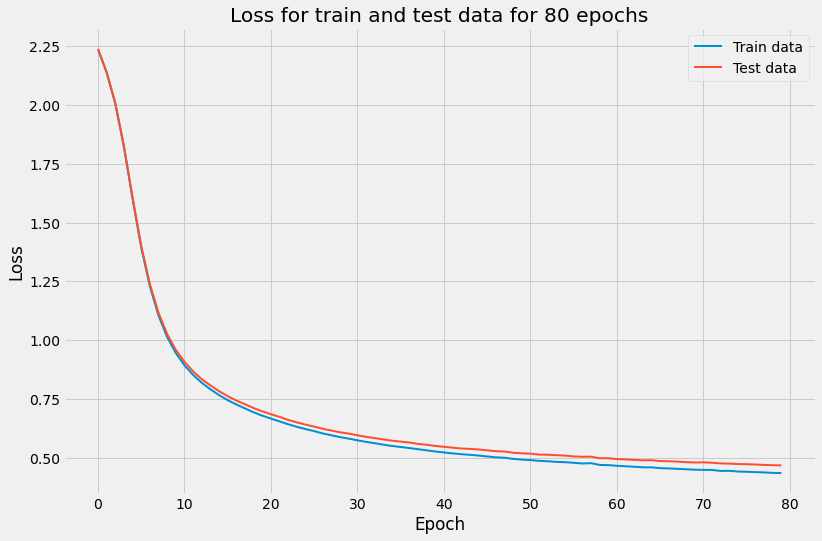

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(80), loss_train_vec80, linewidth=2, label='Train data')
plt.plot(np.arange(80), loss_test_vec80, linewidth=2, label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for train and test data for 80 epochs')
plt.legend()
plt.show()

Naturally, we would expect the model performance to increase as the number of training epochs is increased and we can see that this is true in our case to some degree. We note that the accuracy and loss are improving with each epoch, but the values for the train data and the test data start to diverge (the difference is more notable after $80$ epochs than after $40$ epochs). As we train the model for more epochs, we can only expect the training set loss to go down (and conversely the training set accuracy to go up), as more features are learned from the data and the model predicts better. However, some of these features learned at later times will be specific to the training set and hence will not generalise well for new (unseen) data i.e. the model will start to overfit. In our case, the overfitting is slight even after $80$ epochs, but if we would let the model train longer, we would expect to see a "turn" in the test accuracy and test loss curves i.e. the former will start decreasing and the latter will start increasing at longer times, as opposed to their train data counterparts (that will only keep improving over a longer training period).

## 1.2 Convolutional neural network (CNN) {-}

We will now build a CNN (convolutional neural network) model to perform a classification task on the same Fashion-MNIST data set. The architecture of the CNN is: one input layer (a batch of $28 \times 28$ images passed as an input), five hidden (four convolutional and one fully connected) layers and one output layer with $10$ neurons (one for each class). The four convolutional layers apply $3 \times 3$ filters and the first two layers use $8$ channels, while the last two use $16$ channels. The last convolutional layer is followed by a $2 \times 2$ maximum pooling layer and the fully connected layer has $64$ neurons. The activation function between the hidden layers will be the _LeakyReLU_ function (with a negative slope of $0.01$) and the activation function for the output layer will be the _softmax_ function.

Reloading the data:

In [4]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

We add $1$ more dimension to the data since the 2D convolutional layers in `tensorflow` expect the data to come in the $H \times W \times C$ format (our data set consists of grayscale images, not RGB so $C = 1$).

Loading the data into `tf.data.Dataset` objects:

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# shuffling the data
train_dataset = train_dataset.shuffle(1024)

# batching the data
train_dataset = train_dataset.batch(256)
test_dataset = test_dataset.batch(256)

# prefetching the data
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

2022-03-20 10:58:27.090170: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-20 10:58:27.090486: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Building the CNN model using the `tf.keras.Sequential` class (using the architecture described above):

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

model_init = Sequential([
    Conv2D(8, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),
    Conv2D(8, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Dense(10, activation='softmax')
])

model_init.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

We will use SGD (with a learning rate $\alpha = 10^{-3}$) as our optimizer and categorical cross-entropy (not sparse, since the labels come in the one hot encoded format) as our loss function and compile the model:

In [7]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model_init.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])

Training the model for $40$ epochs:

In [8]:
history = model_init.fit(train_dataset, epochs=40, validation_data=test_dataset)

Epoch 1/40
    235/Unknown - 20s 84ms/step - loss: 2.2832 - accuracy: 0.1487

2022-03-20 10:59:08.433411: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 21s 91ms/step - loss: 2.2832 - accuracy: 0.1487 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/40
234/235 [============================>.] - ETA: 0s - loss: 2.2477 - accuracy: 0.2531

2022-03-20 10:59:29.916506: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 21s 90ms/step - loss: 2.2477 - accuracy: 0.2532 - val_loss: 2.2163 - val_accuracy: 0.3051
Epoch 3/40
234/235 [============================>.] - ETA: 0s - loss: 2.1332 - accuracy: 0.3684

2022-03-20 10:59:51.398854: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 21s 91ms/step - loss: 2.1332 - accuracy: 0.3684 - val_loss: 1.9944 - val_accuracy: 0.4377
Epoch 4/40
234/235 [============================>.] - ETA: 0s - loss: 1.5969 - accuracy: 0.5257

2022-03-20 11:00:13.623258: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 1.5968 - accuracy: 0.5258 - val_loss: 1.1815 - val_accuracy: 0.5905
Epoch 5/40
234/235 [============================>.] - ETA: 0s - loss: 0.9941 - accuracy: 0.6403

2022-03-20 11:00:35.719419: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 94ms/step - loss: 0.9941 - accuracy: 0.6403 - val_loss: 0.9000 - val_accuracy: 0.6631
Epoch 6/40
234/235 [============================>.] - ETA: 0s - loss: 0.8413 - accuracy: 0.6906

2022-03-20 11:00:57.756113: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 94ms/step - loss: 0.8413 - accuracy: 0.6906 - val_loss: 0.8296 - val_accuracy: 0.6919
Epoch 7/40
234/235 [============================>.] - ETA: 0s - loss: 0.7836 - accuracy: 0.7131

2022-03-20 11:01:20.732294: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 98ms/step - loss: 0.7836 - accuracy: 0.7131 - val_loss: 0.7890 - val_accuracy: 0.7155
Epoch 8/40
234/235 [============================>.] - ETA: 0s - loss: 0.7508 - accuracy: 0.7248

2022-03-20 11:01:43.008292: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.7508 - accuracy: 0.7250 - val_loss: 0.7483 - val_accuracy: 0.7287
Epoch 9/40
234/235 [============================>.] - ETA: 0s - loss: 0.7324 - accuracy: 0.7312

2022-03-20 11:02:05.154470: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 94ms/step - loss: 0.7324 - accuracy: 0.7312 - val_loss: 0.7163 - val_accuracy: 0.7328
Epoch 10/40
234/235 [============================>.] - ETA: 0s - loss: 0.7091 - accuracy: 0.7386

2022-03-20 11:02:27.474153: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.7091 - accuracy: 0.7385 - val_loss: 0.7815 - val_accuracy: 0.7121
Epoch 11/40
234/235 [============================>.] - ETA: 0s - loss: 0.6972 - accuracy: 0.7421

2022-03-20 11:02:50.069421: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 0.6972 - accuracy: 0.7420 - val_loss: 0.7028 - val_accuracy: 0.7371
Epoch 12/40
234/235 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.7488

2022-03-20 11:03:12.256932: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6797 - accuracy: 0.7489 - val_loss: 0.7425 - val_accuracy: 0.7034
Epoch 13/40
234/235 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.7541

2022-03-20 11:03:34.989495: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 97ms/step - loss: 0.6664 - accuracy: 0.7541 - val_loss: 0.6606 - val_accuracy: 0.7518
Epoch 14/40
234/235 [============================>.] - ETA: 0s - loss: 0.6553 - accuracy: 0.7578

2022-03-20 11:03:58.924572: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 24s 102ms/step - loss: 0.6553 - accuracy: 0.7578 - val_loss: 0.7446 - val_accuracy: 0.7403
Epoch 15/40
234/235 [============================>.] - ETA: 0s - loss: 0.6451 - accuracy: 0.7602

2022-03-20 11:04:21.510504: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 0.6451 - accuracy: 0.7602 - val_loss: 0.6822 - val_accuracy: 0.7574
Epoch 16/40
234/235 [============================>.] - ETA: 0s - loss: 0.6271 - accuracy: 0.7678

2022-03-20 11:04:44.058674: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 0.6271 - accuracy: 0.7677 - val_loss: 0.6345 - val_accuracy: 0.7599
Epoch 17/40
234/235 [============================>.] - ETA: 0s - loss: 0.6271 - accuracy: 0.7671

2022-03-20 11:05:06.832078: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 97ms/step - loss: 0.6271 - accuracy: 0.7672 - val_loss: 0.6298 - val_accuracy: 0.7638
Epoch 18/40
234/235 [============================>.] - ETA: 0s - loss: 0.6185 - accuracy: 0.7708

2022-03-20 11:05:29.470734: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 0.6185 - accuracy: 0.7708 - val_loss: 0.7612 - val_accuracy: 0.7427
Epoch 19/40
234/235 [============================>.] - ETA: 0s - loss: 0.6204 - accuracy: 0.7699

2022-03-20 11:05:52.074903: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 0.6204 - accuracy: 0.7697 - val_loss: 0.6076 - val_accuracy: 0.7773
Epoch 20/40
234/235 [============================>.] - ETA: 0s - loss: 0.6008 - accuracy: 0.7761

2022-03-20 11:06:14.472579: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 96ms/step - loss: 0.6008 - accuracy: 0.7760 - val_loss: 0.6075 - val_accuracy: 0.7736
Epoch 21/40
234/235 [============================>.] - ETA: 0s - loss: 0.5969 - accuracy: 0.7792

2022-03-20 11:06:37.508183: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 98ms/step - loss: 0.5969 - accuracy: 0.7791 - val_loss: 0.6169 - val_accuracy: 0.7610
Epoch 22/40
234/235 [============================>.] - ETA: 0s - loss: 0.5962 - accuracy: 0.7773

2022-03-20 11:06:59.947524: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 96ms/step - loss: 0.5962 - accuracy: 0.7774 - val_loss: 0.6010 - val_accuracy: 0.7752
Epoch 23/40
234/235 [============================>.] - ETA: 0s - loss: 0.5822 - accuracy: 0.7843

2022-03-20 11:07:22.622193: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 97ms/step - loss: 0.5822 - accuracy: 0.7843 - val_loss: 0.5964 - val_accuracy: 0.7809
Epoch 24/40
234/235 [============================>.] - ETA: 0s - loss: 0.5821 - accuracy: 0.7845

2022-03-20 11:07:45.503669: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 97ms/step - loss: 0.5821 - accuracy: 0.7845 - val_loss: 0.6095 - val_accuracy: 0.7673
Epoch 25/40
234/235 [============================>.] - ETA: 0s - loss: 0.5730 - accuracy: 0.7869

2022-03-20 11:08:08.085574: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 0.5730 - accuracy: 0.7868 - val_loss: 0.6130 - val_accuracy: 0.7687
Epoch 26/40
234/235 [============================>.] - ETA: 0s - loss: 0.5697 - accuracy: 0.7876

2022-03-20 11:08:30.562365: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 96ms/step - loss: 0.5697 - accuracy: 0.7877 - val_loss: 0.6307 - val_accuracy: 0.7609
Epoch 27/40
234/235 [============================>.] - ETA: 0s - loss: 0.5600 - accuracy: 0.7921

2022-03-20 11:08:53.141998: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 0.5600 - accuracy: 0.7921 - val_loss: 0.6108 - val_accuracy: 0.7702
Epoch 28/40
234/235 [============================>.] - ETA: 0s - loss: 0.5640 - accuracy: 0.7907

2022-03-20 11:09:15.569969: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5640 - accuracy: 0.7908 - val_loss: 0.5866 - val_accuracy: 0.7725
Epoch 29/40
234/235 [============================>.] - ETA: 0s - loss: 0.5549 - accuracy: 0.7939

2022-03-20 11:09:37.852430: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5549 - accuracy: 0.7939 - val_loss: 0.5636 - val_accuracy: 0.7932
Epoch 30/40
234/235 [============================>.] - ETA: 0s - loss: 0.5429 - accuracy: 0.7989

2022-03-20 11:10:00.245252: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5429 - accuracy: 0.7988 - val_loss: 0.5595 - val_accuracy: 0.7941
Epoch 31/40
234/235 [============================>.] - ETA: 0s - loss: 0.5466 - accuracy: 0.7995

2022-03-20 11:10:22.668393: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5466 - accuracy: 0.7996 - val_loss: 0.5538 - val_accuracy: 0.7932
Epoch 32/40
234/235 [============================>.] - ETA: 0s - loss: 0.5445 - accuracy: 0.7991

2022-03-20 11:10:45.417106: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 97ms/step - loss: 0.5445 - accuracy: 0.7990 - val_loss: 0.6140 - val_accuracy: 0.7685
Epoch 33/40
234/235 [============================>.] - ETA: 0s - loss: 0.5386 - accuracy: 0.8009

2022-03-20 11:11:08.264155: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 97ms/step - loss: 0.5386 - accuracy: 0.8008 - val_loss: 0.5701 - val_accuracy: 0.7909
Epoch 34/40
234/235 [============================>.] - ETA: 0s - loss: 0.5357 - accuracy: 0.8026

2022-03-20 11:11:31.169738: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 97ms/step - loss: 0.5357 - accuracy: 0.8026 - val_loss: 0.5542 - val_accuracy: 0.7989
Epoch 35/40
234/235 [============================>.] - ETA: 0s - loss: 0.5294 - accuracy: 0.8052

2022-03-20 11:11:53.920232: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 97ms/step - loss: 0.5294 - accuracy: 0.8052 - val_loss: 0.5442 - val_accuracy: 0.7998
Epoch 36/40
234/235 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.8053

2022-03-20 11:12:16.813248: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 99ms/step - loss: 0.5287 - accuracy: 0.8054 - val_loss: 0.5944 - val_accuracy: 0.7866
Epoch 37/40
234/235 [============================>.] - ETA: 0s - loss: 0.5245 - accuracy: 0.8072

2022-03-20 11:12:42.638893: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 26s 109ms/step - loss: 0.5245 - accuracy: 0.8073 - val_loss: 0.5442 - val_accuracy: 0.8012
Epoch 38/40
234/235 [============================>.] - ETA: 0s - loss: 0.5207 - accuracy: 0.8084

2022-03-20 11:13:06.475264: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 24s 102ms/step - loss: 0.5207 - accuracy: 0.8083 - val_loss: 0.5472 - val_accuracy: 0.7956
Epoch 39/40
234/235 [============================>.] - ETA: 0s - loss: 0.5169 - accuracy: 0.8111

2022-03-20 11:13:30.008142: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 99ms/step - loss: 0.5169 - accuracy: 0.8112 - val_loss: 0.5310 - val_accuracy: 0.8026
Epoch 40/40
234/235 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.8112

2022-03-20 11:13:52.107514: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]



235/235 [==============================] - 22s 94ms/step - loss: 0.5128 - accuracy: 0.8112 - val_loss: 0.6002 - val_accuracy: 0.7807


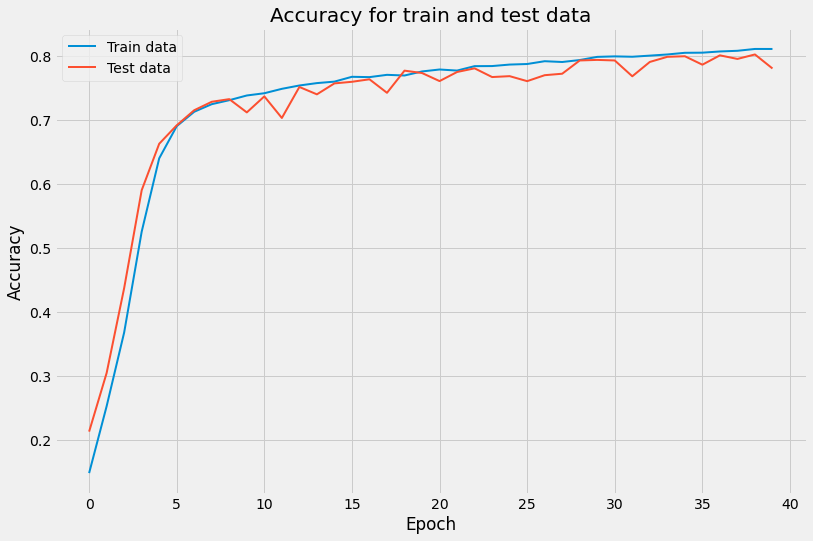

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], linewidth=2, label='Train data')
plt.plot(history.history['val_accuracy'], linewidth=2, label='Test data')
plt.title('Accuracy for train and test data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

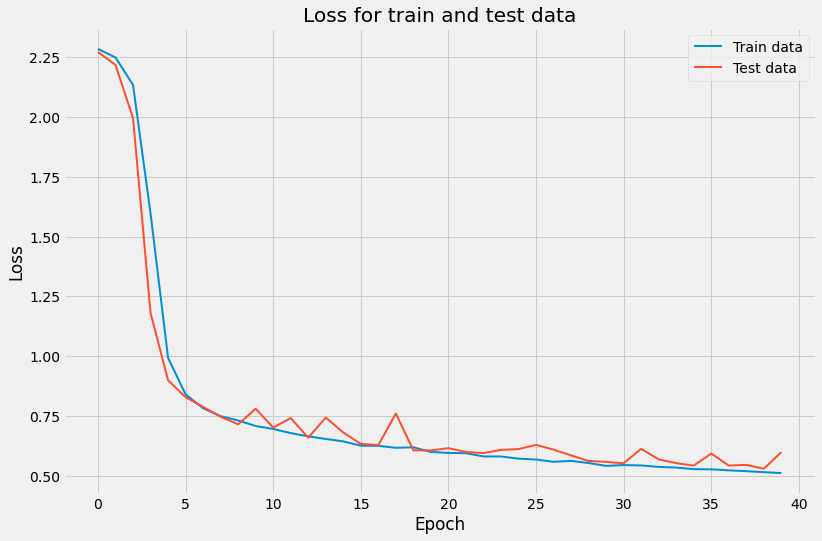

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], linewidth=2, label='Train data')
plt.plot(history.history['val_loss'], linewidth=2, label='Test data')
plt.title('Loss for train and test data')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We can see that the CNN model is very similar to the MLP model in terms of performance (just over $80 \%$ accuracy and a loss of $0.5$ after $40$ epochs for _both_ the train data and the test data; this is more remarkable for the CNN model since it has $10$ times less parameters than the MLP). In terms of convergence rate, they are also comparable: both models reach $70 \%$ accuracy relatively quick (after less than $10$ epochs) and then the improvement slows down (only a $10 \%$ accuracy increase over the next $30$ epochs). One important distinction between the two models is the smoothness of the curves: while the curves (accuracy and loss over the epochs) for the training set are smooth in both cases, we note that in the case of the CNN, the curves for the test set are very noisy (as opposed to what was observed for the MLP). This may suggest that some of the features present in the training set learned by the model in the convolutional layers do not generalize well. We will next see a potential fix for this problem.

### Incorporating dropout in the fully connected layer

We will now incorporate dropout in the fully connected layer and explore its effect on the model performance and convergence. We will scan over a suitable range of the dropout probability (range $[0.1, 0.9]$ in steps of $0.1$) to find an optimal value of this dropout probability. We will use $80 \%$ of the training set for the actual training and leave $20 \%$ out for validation and use the accuracy on the validation set as the measure of performance for this search.

Loading the nine models into a Python dictionary:

In [111]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [112]:
from tensorflow.keras.layers import Dropout

# dropout probability range
rate_vals = [round(0.1 * x, 2) for x in range(1, 10)]

dropout_models = {}

# for each dropout rate...
for rate in rate_vals:
    #... create model with dropout in the fully connected layer
    model = Sequential([
        Conv2D(8, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),
        Conv2D(8, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        MaxPool2D((2, 2)),
        Flatten(),
        Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        Dropout(rate),
        Dense(10, activation='softmax')
    ], name=str(rate))
    
    #... compile the model
    model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
    
    #... append model to dictionary
    dropout_models[rate] = model

Reloading the data:

In [113]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

We cannot use the `validation_split` argument of the `tf.Sequential.fit()` method (since our data comes in batches), so we need to divide the training set into an actual training set and a validation set:

In [114]:
def train_val_split(x_train, y_train, rate=0.8):
    np.random.seed(42)

    # permute indices
    perm_ind = np.random.permutation(np.arange(x_train.shape[0]))
    
    # compute number of images in the training set
    perc = int(x_train.shape[0] * rate)

    # get indices for training and validation sets
    split_ind = (perm_ind[perc:], perm_ind[:perc])

    # get validation set
    x_val = x_train[split_ind[0], ...]
    y_val = y_train[split_ind[0], ...]
    
    # get training set
    x_train = x_train[split_ind[1], ...]
    y_train = y_train[split_ind[1], ...]
    
    return x_train, y_train, x_val, y_val

Splitting the training set:

In [115]:
x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)

Loading the data into `tf.data.Dataset` objects:

In [120]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_dataset = train_dataset.shuffle(1024)

train_dataset = train_dataset.batch(256)
val_dataset = val_dataset.batch(256)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Training the models with different dropout rates after the fully connected layer and storing the validation accuracy after $40$ epochs:

In [182]:
val_accuracy = {}

# for each dropout rate
for rate in rate_vals:
    
    # select model
    model = dropout_models[rate]
    
    # train model
    history = model.fit(train_dataset, epochs=40, validation_data=val_dataset, verbose=0)
    
    # get accuracy for the validation set after 40 epochs
    acc = history.history['val_accuracy'][-1]
    print('Tried rate = {}; Validation accuracy = {}'.format(rate, acc))
    
    # store the accuracy in the dictionary
    val_accuracy[rate] = acc

2022-03-18 00:23:02.447253: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:23:19.800941: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:23:36.969573: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:23:54.155259: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:24:11.375714: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:24:28.552737: W tensorflow/core/comm

Tried rate = 0.1; Validation accuracy = 0.8012499809265137


2022-03-18 00:34:34.710194: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:34:52.250493: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:35:09.591798: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:35:26.889154: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:35:44.135088: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:36:01.461704: W tensorflow/core/comm

Tried rate = 0.2; Validation accuracy = 0.7955833077430725


2022-03-18 00:46:08.385453: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:46:25.957229: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:46:43.308777: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:47:00.630757: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:47:17.997327: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:47:35.306567: W tensorflow/core/comm

Tried rate = 0.3; Validation accuracy = 0.7774166464805603


2022-03-18 00:57:43.335644: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:58:00.873156: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:58:18.179227: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:58:35.524516: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:58:52.869862: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 00:59:10.265916: W tensorflow/core/comm

Tried rate = 0.4; Validation accuracy = 0.7772499918937683


2022-03-18 01:09:18.461120: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:09:36.041179: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:09:53.423872: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:10:10.752938: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:10:28.072005: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:10:45.410260: W tensorflow/core/comm

Tried rate = 0.5; Validation accuracy = 0.7705833315849304


2022-03-18 01:20:54.641555: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:21:12.317186: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:21:29.668459: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:21:47.086183: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:22:04.443167: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:22:21.824987: W tensorflow/core/comm

Tried rate = 0.6; Validation accuracy = 0.7733333110809326


2022-03-18 01:32:32.089659: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:32:50.006173: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:33:07.537341: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:33:25.007503: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:33:42.435444: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:33:59.869351: W tensorflow/core/comm

Tried rate = 0.7; Validation accuracy = 0.765250027179718


2022-03-18 01:49:19.148880: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:50:06.250557: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 01:51:00.081650: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 02:39:25.062309: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 02:39:54.045016: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 02:40:22.530921: W tensorflow/core/comm

Tried rate = 0.8; Validation accuracy = 0.7523333430290222


2022-03-18 02:51:09.318588: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 02:51:26.907249: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 02:51:44.313128: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 02:52:01.770003: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 02:52:19.154869: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2022-03-18 02:52:36.657802: W tensorflow/core/comm

Tried rate = 0.9; Validation accuracy = 0.7115833163261414


In [183]:
val_accuracy

{0.1: 0.80125,
 0.2: 0.7955833,
 0.3: 0.77741665,
 0.4: 0.77725,
 0.5: 0.77058333,
 0.6: 0.7733333,
 0.7: 0.76525,
 0.8: 0.75233334,
 0.9: 0.7115833}

### Retraining model with optimal dropout rate

We will now retrain our CNN model, incorporating dropout in the fully connected layer (with the optimal dropout rate computed before):

In [15]:
rate = max(val_accuracy, key=val_accuracy.get)

print('Optimal dropout rate: {}'.format(rate))

Optimal dropout rate: 0.1


Building the model:

In [16]:
dropout_model = Sequential([
    Conv2D(8, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),
    Conv2D(8, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(rate),
    Dense(10, activation='softmax')
])

dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 16)        1168      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

Compiling the model:

In [17]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

dropout_model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])

Reloading the data:

In [19]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

Loading the data into `tf.data.Dataset` objects:

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(1024)

train_dataset = train_dataset.batch(256)
test_dataset = test_dataset.batch(256)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Training the model for $40$ epochs:

In [21]:
dropout_history = dropout_model.fit(train_dataset, epochs=40, validation_data=test_dataset)

Epoch 1/40
    235/Unknown - 20s 86ms/step - loss: 2.2972 - accuracy: 0.1472

2022-03-18 12:50:40.479237: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 94ms/step - loss: 2.2972 - accuracy: 0.1472 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/40
234/235 [============================>.] - ETA: 0s - loss: 2.2915 - accuracy: 0.1695

2022-03-18 12:51:02.388998: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 93ms/step - loss: 2.2915 - accuracy: 0.1695 - val_loss: 2.2889 - val_accuracy: 0.1790
Epoch 3/40
234/235 [============================>.] - ETA: 0s - loss: 2.2853 - accuracy: 0.1820

2022-03-18 12:51:24.584793: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 94ms/step - loss: 2.2853 - accuracy: 0.1820 - val_loss: 2.2820 - val_accuracy: 0.1920
Epoch 4/40
234/235 [============================>.] - ETA: 0s - loss: 2.2768 - accuracy: 0.2011

2022-03-18 12:51:46.931852: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 2.2768 - accuracy: 0.2010 - val_loss: 2.2719 - val_accuracy: 0.2078
Epoch 5/40
234/235 [============================>.] - ETA: 0s - loss: 2.2638 - accuracy: 0.2135

2022-03-18 12:52:09.461833: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 2.2638 - accuracy: 0.2135 - val_loss: 2.2548 - val_accuracy: 0.2248
Epoch 6/40
234/235 [============================>.] - ETA: 0s - loss: 2.2392 - accuracy: 0.2353

2022-03-18 12:52:31.774534: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 2.2392 - accuracy: 0.2353 - val_loss: 2.2194 - val_accuracy: 0.2569
Epoch 7/40
234/235 [============================>.] - ETA: 0s - loss: 2.1808 - accuracy: 0.2720

2022-03-18 12:52:53.969751: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 94ms/step - loss: 2.1808 - accuracy: 0.2719 - val_loss: 2.1236 - val_accuracy: 0.3386
Epoch 8/40
234/235 [============================>.] - ETA: 0s - loss: 1.9867 - accuracy: 0.3644

2022-03-18 12:53:16.115444: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 94ms/step - loss: 1.9867 - accuracy: 0.3644 - val_loss: 1.7433 - val_accuracy: 0.4968
Epoch 9/40
234/235 [============================>.] - ETA: 0s - loss: 1.4138 - accuracy: 0.5266

2022-03-18 12:53:38.436909: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 1.4138 - accuracy: 0.5268 - val_loss: 1.0769 - val_accuracy: 0.6294
Epoch 10/40
234/235 [============================>.] - ETA: 0s - loss: 1.0618 - accuracy: 0.6096

2022-03-18 12:54:00.670672: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 1.0618 - accuracy: 0.6096 - val_loss: 0.9215 - val_accuracy: 0.6582
Epoch 11/40
234/235 [============================>.] - ETA: 0s - loss: 0.9475 - accuracy: 0.6481

2022-03-18 12:54:22.982886: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.9475 - accuracy: 0.6481 - val_loss: 0.8494 - val_accuracy: 0.6891
Epoch 12/40
234/235 [============================>.] - ETA: 0s - loss: 0.8786 - accuracy: 0.6765

2022-03-18 12:54:45.395925: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.8786 - accuracy: 0.6766 - val_loss: 0.8140 - val_accuracy: 0.7043
Epoch 13/40
234/235 [============================>.] - ETA: 0s - loss: 0.8328 - accuracy: 0.6949

2022-03-18 12:55:07.675009: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.8328 - accuracy: 0.6950 - val_loss: 0.7705 - val_accuracy: 0.7175
Epoch 14/40
234/235 [============================>.] - ETA: 0s - loss: 0.7979 - accuracy: 0.7058

2022-03-18 12:55:29.950401: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.7979 - accuracy: 0.7058 - val_loss: 0.7484 - val_accuracy: 0.7209
Epoch 15/40
234/235 [============================>.] - ETA: 0s - loss: 0.7706 - accuracy: 0.7171

2022-03-18 12:55:52.240060: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.7706 - accuracy: 0.7171 - val_loss: 0.7250 - val_accuracy: 0.7279
Epoch 16/40
234/235 [============================>.] - ETA: 0s - loss: 0.7484 - accuracy: 0.7237

2022-03-18 12:56:14.543125: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.7484 - accuracy: 0.7238 - val_loss: 0.7116 - val_accuracy: 0.7347
Epoch 17/40
234/235 [============================>.] - ETA: 0s - loss: 0.7333 - accuracy: 0.7298

2022-03-18 12:56:36.884065: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.7333 - accuracy: 0.7298 - val_loss: 0.7025 - val_accuracy: 0.7362
Epoch 18/40
234/235 [============================>.] - ETA: 0s - loss: 0.7202 - accuracy: 0.7324

2022-03-18 12:56:59.178752: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.7202 - accuracy: 0.7325 - val_loss: 0.6847 - val_accuracy: 0.7436
Epoch 19/40
234/235 [============================>.] - ETA: 0s - loss: 0.7044 - accuracy: 0.7403

2022-03-18 12:57:21.383555: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.7044 - accuracy: 0.7405 - val_loss: 0.6716 - val_accuracy: 0.7494
Epoch 20/40
234/235 [============================>.] - ETA: 0s - loss: 0.6903 - accuracy: 0.7468

2022-03-18 12:57:43.594849: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6903 - accuracy: 0.7469 - val_loss: 0.6634 - val_accuracy: 0.7531
Epoch 21/40
234/235 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.7498

2022-03-18 12:58:05.837689: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6796 - accuracy: 0.7499 - val_loss: 0.6474 - val_accuracy: 0.7586
Epoch 22/40
234/235 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.7534

2022-03-18 12:58:28.183114: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6708 - accuracy: 0.7535 - val_loss: 0.6550 - val_accuracy: 0.7537
Epoch 23/40
234/235 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.7557

2022-03-18 12:58:50.481622: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6606 - accuracy: 0.7558 - val_loss: 0.6352 - val_accuracy: 0.7587
Epoch 24/40
234/235 [============================>.] - ETA: 0s - loss: 0.6504 - accuracy: 0.7595

2022-03-18 12:59:12.773667: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6504 - accuracy: 0.7595 - val_loss: 0.6447 - val_accuracy: 0.7582
Epoch 25/40
234/235 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.7645

2022-03-18 12:59:35.026494: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6427 - accuracy: 0.7645 - val_loss: 0.6206 - val_accuracy: 0.7645
Epoch 26/40
234/235 [============================>.] - ETA: 0s - loss: 0.6363 - accuracy: 0.7665

2022-03-18 12:59:57.225826: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 94ms/step - loss: 0.6363 - accuracy: 0.7665 - val_loss: 0.6164 - val_accuracy: 0.7683
Epoch 27/40
234/235 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.7683

2022-03-18 13:00:19.610624: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6289 - accuracy: 0.7683 - val_loss: 0.6196 - val_accuracy: 0.7674
Epoch 28/40
234/235 [============================>.] - ETA: 0s - loss: 0.6214 - accuracy: 0.7715

2022-03-18 13:00:42.152036: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 23s 96ms/step - loss: 0.6214 - accuracy: 0.7716 - val_loss: 0.6092 - val_accuracy: 0.7698
Epoch 29/40
234/235 [============================>.] - ETA: 0s - loss: 0.6155 - accuracy: 0.7747

2022-03-18 13:01:04.486399: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6155 - accuracy: 0.7746 - val_loss: 0.6080 - val_accuracy: 0.7723
Epoch 30/40
234/235 [============================>.] - ETA: 0s - loss: 0.6065 - accuracy: 0.7786

2022-03-18 13:01:26.814470: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6065 - accuracy: 0.7786 - val_loss: 0.5982 - val_accuracy: 0.7811
Epoch 31/40
234/235 [============================>.] - ETA: 0s - loss: 0.6060 - accuracy: 0.7772

2022-03-18 13:01:49.052911: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.6060 - accuracy: 0.7772 - val_loss: 0.5847 - val_accuracy: 0.7865
Epoch 32/40
234/235 [============================>.] - ETA: 0s - loss: 0.5992 - accuracy: 0.7818

2022-03-18 13:02:11.319298: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5992 - accuracy: 0.7818 - val_loss: 0.5839 - val_accuracy: 0.7842
Epoch 33/40
234/235 [============================>.] - ETA: 0s - loss: 0.5975 - accuracy: 0.7808

2022-03-18 13:02:33.615878: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5975 - accuracy: 0.7808 - val_loss: 0.5801 - val_accuracy: 0.7868
Epoch 34/40
234/235 [============================>.] - ETA: 0s - loss: 0.5890 - accuracy: 0.7829

2022-03-18 13:02:55.941806: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5890 - accuracy: 0.7829 - val_loss: 0.5812 - val_accuracy: 0.7822
Epoch 35/40
234/235 [============================>.] - ETA: 0s - loss: 0.5869 - accuracy: 0.7852

2022-03-18 13:03:18.210184: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5869 - accuracy: 0.7852 - val_loss: 0.5993 - val_accuracy: 0.7729
Epoch 36/40
234/235 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.7876

2022-03-18 13:03:40.431017: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5816 - accuracy: 0.7875 - val_loss: 0.5679 - val_accuracy: 0.7883
Epoch 37/40
234/235 [============================>.] - ETA: 0s - loss: 0.5760 - accuracy: 0.7888

2022-03-18 13:04:02.670354: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5760 - accuracy: 0.7887 - val_loss: 0.5676 - val_accuracy: 0.7868
Epoch 38/40
234/235 [============================>.] - ETA: 0s - loss: 0.5757 - accuracy: 0.7914

2022-03-18 13:04:25.016353: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5757 - accuracy: 0.7914 - val_loss: 0.5780 - val_accuracy: 0.7874
Epoch 39/40
234/235 [============================>.] - ETA: 0s - loss: 0.5711 - accuracy: 0.7922

2022-03-18 13:04:47.301781: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


235/235 [==============================] - 22s 95ms/step - loss: 0.5711 - accuracy: 0.7923 - val_loss: 0.5627 - val_accuracy: 0.7874
Epoch 40/40
234/235 [============================>.] - ETA: 0s - loss: 0.5645 - accuracy: 0.7941

2022-03-18 13:05:09.468245: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]



235/235 [==============================] - 22s 95ms/step - loss: 0.5645 - accuracy: 0.7941 - val_loss: 0.5825 - val_accuracy: 0.7783


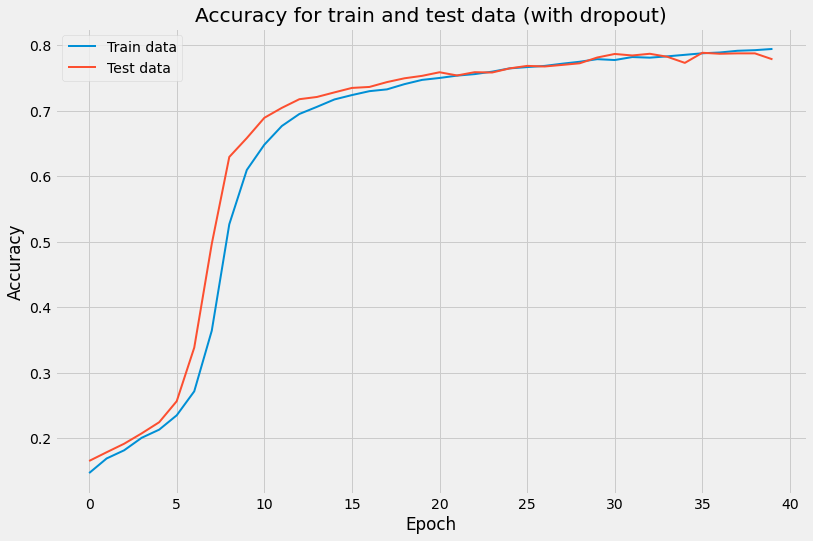

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(dropout_history.history['accuracy'], linewidth=2, label='Train data')
plt.plot(dropout_history.history['val_accuracy'], linewidth=2, label='Test data')
plt.title('Accuracy for train and test data (with dropout)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

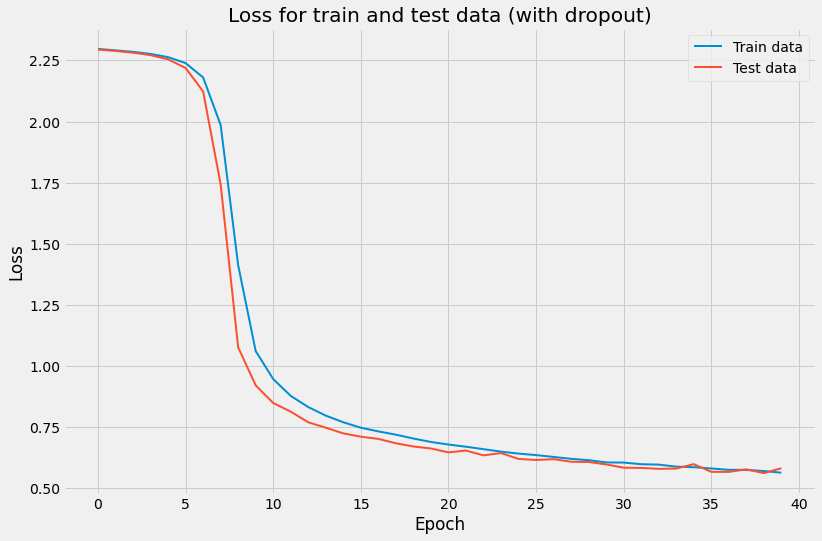

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(dropout_history.history['loss'], linewidth=2, label='Train data')
plt.plot(dropout_history.history['val_loss'], linewidth=2, label='Test data')
plt.title('Loss for train and test data (with dropout)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We can see that the CNN model with dropout is comparable to the one without dropout (again, both in terms of accuracy and loss after $40$ epochs). The model with dropout converges slightly slower (this is to be expected since only a fraction of the neurons in the fully connected layer are used for learning during training), but differs from the model without dropout in one key aspect: the behaviour of the accuracy and loss curves for the test set. We can see that the test set curves are not as noisy as they were for the previous model (the sudden jumps have a much lower magnitude) and they follow their training set counterparts much closely (for the CNN model without dropout, after a number of iterations we would see them slowly start to diverge i.e. a worse performance for the test set than for the train set). These are both instances of overfitting prevention so we can conclude that incorporating dropout in the model improves robustness and generalisability.

Lastly, we will look at how the features are learned by the fully connected layer in the two models. Specifically, we will do this by looking at the activations of the hidden units of the fully connected layer when the model is evaluated on the test set (for both the CNN with and without dropout).

In [46]:
from tensorflow.keras.models import Model

dropout_inputs = dropout_model.inputs
dropout_outputs = dropout_model.layers[6].output
dropout_m = Model(inputs=dropout_inputs, outputs=dropout_outputs)

inputs = model_init.inputs
outputs = model_init.layers[6].output
m = Model(inputs=inputs, outputs=outputs)

Computing the post-activations in the fully connected layer (for the test set):

In [47]:
dropout_act = dropout_m(x_test)
act = m(x_test)

Text(0.5, 1.0, 'Without dropout')

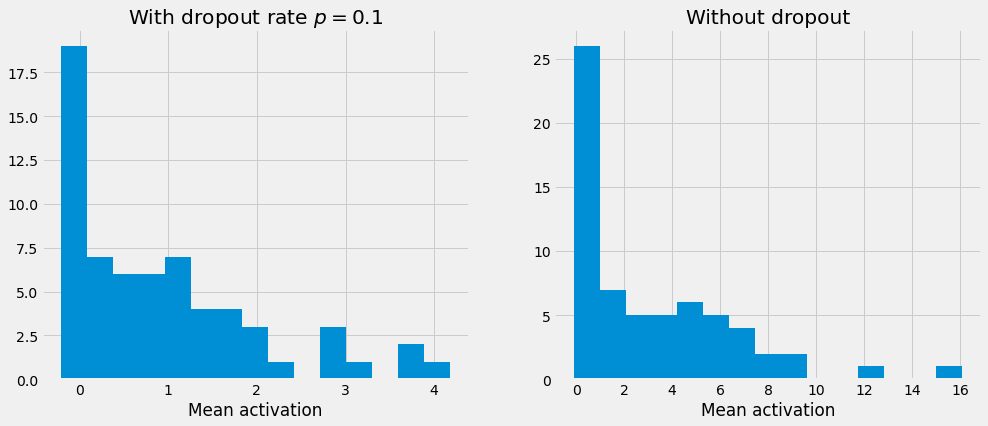

In [54]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.hist(dropout_act.numpy().mean(axis=0), bins=15)
plt.xlabel('Mean activation')
plt.title('With dropout rate 'r'$p = $'+str(rate))
plt.subplot(1, 2, 2)
plt.hist(act.numpy().mean(axis=0), bins=15)
plt.xlabel('Mean activation')
plt.title('Without dropout')

Text(0.5, 1.0, 'Without dropout')

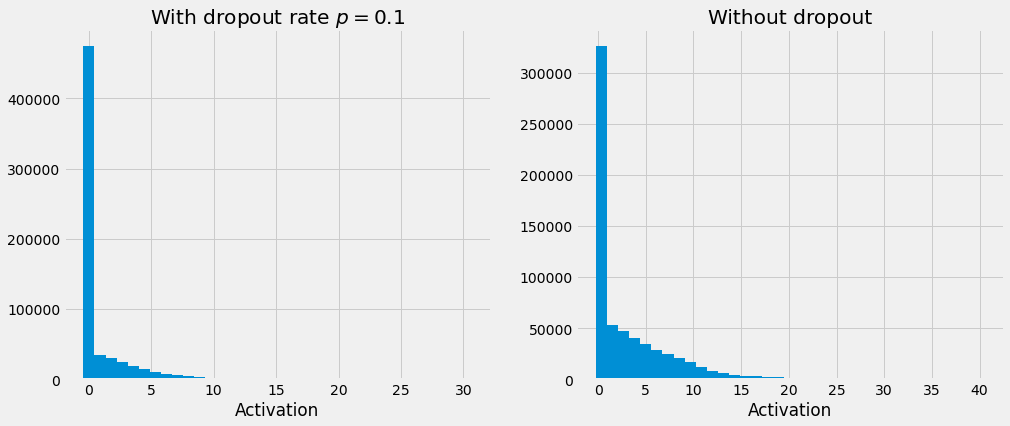

In [52]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.hist(dropout_act.numpy().reshape(x_test.shape[0] * 64), bins=35)
plt.xlabel('Activation')
plt.title('With dropout rate 'r'$p = $'+str(rate))
plt.subplot(1, 2, 2)
plt.hist(act.numpy().reshape(x_test.shape[0] * 64), bins=35)
plt.xlabel('Activation')
plt.title('Without dropout')

We can see that when dropout is incorporated into the model, there are (significantly) less non-zero activations (and naturally, more zero activations) in the fully connected layer for the test set. It is true that the difference between the number of zero and non-zero activations in the CNN models with and without dropout is not very dramatic, but this can be explained by the relatively low dropout rate used i.e. $p = 0.1$. This is a clear illustration of dropout preventing neurons from co-adapting (neurons in the fully connected layer are no longer able to depend on any other specific neurons being present, and so each neuron tries to individually detect image features). This explains why the CNN model with dropout tends to be more robust and to generalize better than the CNN model without dropout.

To conclude our comparison between different models, we note that the CNN with dropout in the fully connected layer is very similar to the first MLP model considered previously (in terms of loss rate of convergence and accuracy as a function of the number of epochs but also in terms of robustness and generalisability). This is quite remarkable for the CNN, since this model has $10$ times less parameters than the MLP (indirectly reducing the overfitting caused by overparametrisation) and still manages to achieve the same desirable properties of a neural network model achieved by the MLP.

### Visualising feature map

Lastly, we will look at the convolutional layers of the CNN model (i.e. extracting one feature map from each layer and visualising it on a single image from the test set).

In [43]:
inputs = dropout_model.inputs
outputs = [dropout_model.layers[i].output for i in range(4)]
features_m = Model(inputs=inputs, outputs=outputs)

Selecting the first image from the test set and computing the post-activation values in the convolutional layers (across all channels in the layer; only one channel will be selected from each layer for visualisation):

In [61]:
image = x_test[0, ...]
image_tf = image.reshape(1, 28, 28, 1)

features = features_m(image_tf)
features = [image] + features

Plotting the post-activation values in the convolutional layers:

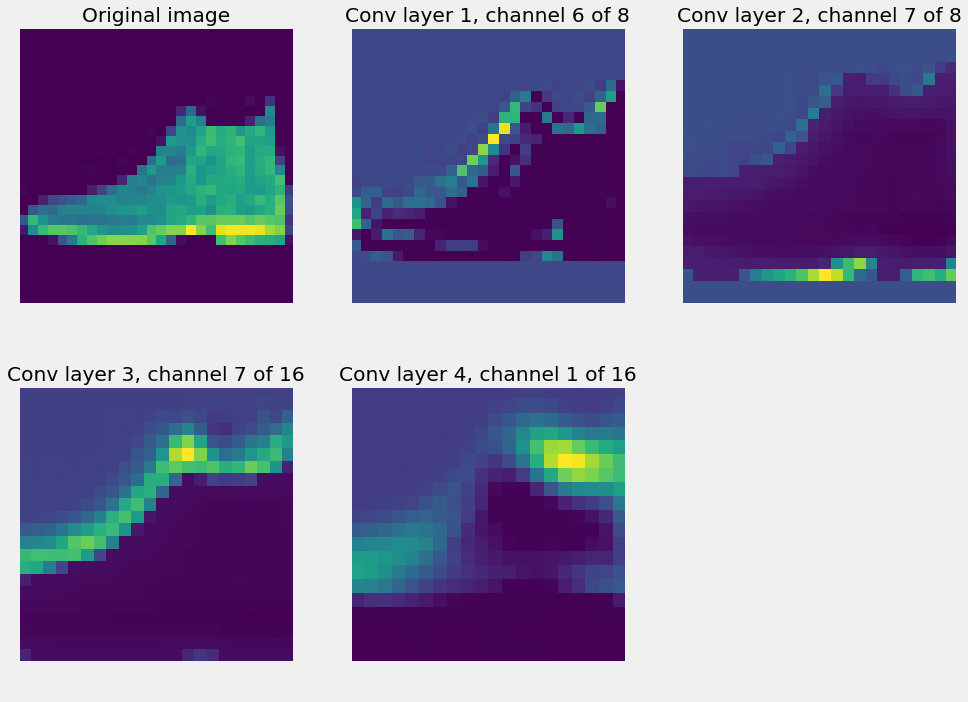

In [110]:
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

axes[1, 2].get_xaxis().set_visible(False)
axes[1, 2].get_yaxis().set_visible(False)

channels = [5, 6, 6, 0]

for i in range(len(features)):

    feature_map = features[i]
    num_channels = feature_map.shape[-1]

    row = i // n_cols
    col = i % n_cols

    if i == 0:
        axes[row, col].imshow(image)
        axes[row, col].set_title('Original image')
    else:
        axes[row, col].imshow(feature_map[0, ..., channels[i-1]])
        axes[row, col].set_title('Conv layer {}, channel {} of {}'.format(i, channels[i-1] + 1, num_channels))
        
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)

For the first $3$ convolutional layers, we can see that the channels presented above detect edges in the image: the channel on the first convolutional layer detects the top left (curved) edge of the image (and roughly the general shape of the image), the channel on the second convolutional layer detects the bottom (straight) edge of the image and the channel on the third convolutional layer detects (again) the top left (curved) edge of the image and the top (straight) edge of the image (on this layer, the neurons are more precise in detecting these edges as opposed to the neurons on the first layer). On the last convolutional layer, it is harder to distinguish what exactly the neurons detect (we can see that most of them activate on the top right edge of the image and some activate in the bottom left). Hence, we can see that more complicated (and less sharp and interpretable) features are detected in the deeper convolutional layers of the model.

# Task 2: Unsupervised learning {-}

We will now turn our focus from neural networks to unsupervised learning algorithms (dimensionality reduction and clustering). Specifically, we will consider the first $N = 1000$ images in the Fashion-MNIST data set and we will carry out a PCA (principal component analysis) and $k$-means clustering on this set.

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data {-}

Selecting the first $N = 1000$ images (and reshaping them from $28 \times 28$-dimensional arrays to $784$-dimensional vectors):

In [12]:
X = x_train[:1000, ...]
X = X.reshape(1000, 784)

Standardising the data:

In [13]:
def standardise(X):
    
    # getting the mean and standard deviation of each column
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    # replacing 0 variances with 1 (to avoid division by 0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    
    # standardising the data
    Xbar = (X - mu) / std_filled
    return Xbar

In [14]:
X = standardise(X)

We will now perform PCA to carry out dimensional reduction. We will use the centered data matrix computed before
$$\mathcal{X}_{N \times p} = X - \frac{1}{N} \mathbf{1}\mathbf{1}^T X$$

to get the (centered) sample covariance matrix
$$C_X = (\mathcal{X}^T \mathcal{X})_{p \times p} \text{.}$$

To reduce the data to its first $m$ principal components, we will compute the first $m$ eigenvalues of $C_X$ (ordered in descending order) and their corresponding eigenvectors. The PCA space of $X$ (for these $m$ components) will then be
$$(X_{PCA})_{N \times m} = \mathcal{X}_{N \times p} U_{p \times m}$$

where $U_{p \times m}$ is the matrix containing the first $m$ eigenvectors of $C_X$.

In [15]:
def pca(X, m):
    
    # compute (centered) sample covariance matrix C
    C = 1. / (len(X) - 1) * np.dot(X.T, X)
    
    # get first (largest) m eigenvectors and corresponding eigenvectors of C
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which='LM', return_eigenvectors=True)
    
    # sort the eigenvalues (and eigenvectors) in descending order
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:, sorted_index]
    
    # get PCA space of X
    X_pca = X.dot(eigenvectors)
    
    return X_pca, eigenvectors, eigenvalues

Having computed the first $m$ principal components of the data matrix $X$, we can compute the variance explained by these components as
$$\frac{1}{\text{Tr}(C_X)} \sum_{i=1}^m \lambda_i$$

where $\text{Tr}(C_X)$ is the sum of all eigenvalues of $C_X$ and $\lambda_i$ ($i = 1, ..., m$) are the first $m$ eigenvalues of $C_X$. In particular, the variance explained by the $j$-th principal component of $X$ can be computed as $\lambda_j / \text{Tr}(C_X)$.

In [16]:
def variance_explained(X, eigenvalues):
    
    # compute (centered) sample covariance matrix C
    C = 1. / (len(X) - 1) * np.dot(X.T, X)
    
    # compute sum of eigenvalues of C
    all_eigenvalues, _ = np.linalg.eig(C)
    total_variance = abs(all_eigenvalues.sum())
    
    # compute the explained variance for each principal component
    explained_variances = eigenvalues / total_variance
    
    return explained_variances

Finally, we will compute the first $m = 25$ components of our data matrix $X$:

In [17]:
_, _, eigenvalues = pca(X, 25)

And the fraction of variance explained by these components:

In [18]:
var_exp = np.cumsum(variance_explained(X, eigenvalues))

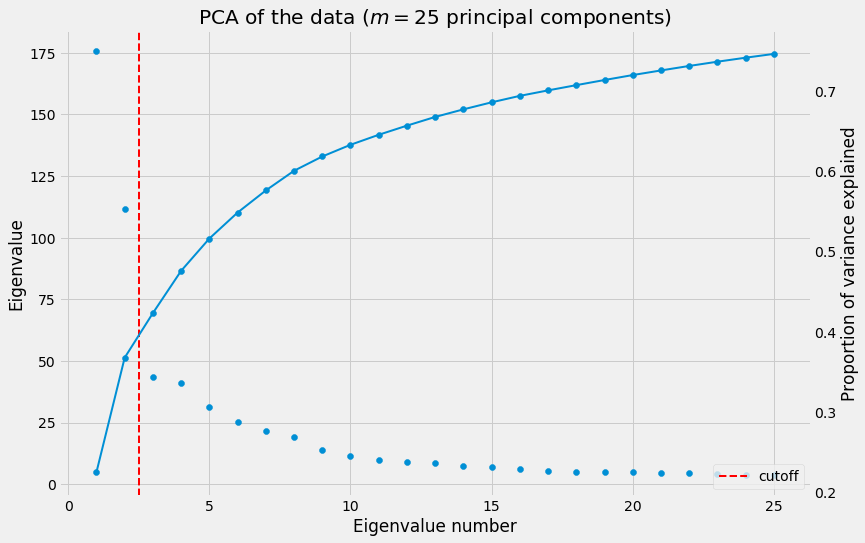

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(np.arange(1, 26), eigenvalues)
ax.set_xlabel('Eigenvalue number')
ax.set_ylabel('Eigenvalue')
ax.axvline(2.5, c='red', linestyle='--', linewidth=2, label='cutoff')
ax.set_title('PCA of the data 'r'$(m = 25$'' principal components)')
ax.legend(loc='lower right')

ax2 = ax.twinx()
ax2.plot(np.arange(1, 26), var_exp, linewidth=2)
ax2.scatter(np.arange(1, 26), var_exp)
ax2.set_ylabel('Proportion of variance explained')
ax2.grid(False)

We can see that there are significant drops in the eigenvalues after eigenvalue $1$, $2$ and (to a lesser degree) $4$. Deciding on a good value for $m$ is quite natural in this case: the first two eigenvalues have similar magnitude and the dropoff is most drastic after the second eigenvalue. Additionaly, $m = 2$ dimensions are very easy to represent (plot) and visualize, and the first two principal components explain a fair amount of the total variance of the data (approximately $40 \%$ of the variance explained by only $2$ variables, as opposed to the $784$ features in the original data set). Hence, $m = 2$ is a sensible choice (alternatively, we can consider the first $m = 4$ principal components to gain an additional $10 \%$ variance explained, but we lose the ability to visually represent the PCA space of the data). _Note:_ if we instead decided to choose $m$ based on the proportion of variance explained by the first $m$ principal components (e.g. by setting a threshold of $80 \%$), we can see that more than $25$ components are needed; in this case, there is a clear drop in the eigenvalues so we can use this criterion instead.

We will now consider the first $m = 2$ principal components and produce a plot of the data in the PCA space spanned by these $m = 2$ components, coloring each point according to its image class.

In [20]:
targets = np.argmax(y_train[:1000, :], axis=1)

In [21]:
X_pca, _, _ = pca(X, 2)

Text(0.5,1,'PCA space of the data $(m = 2$ principal components)')

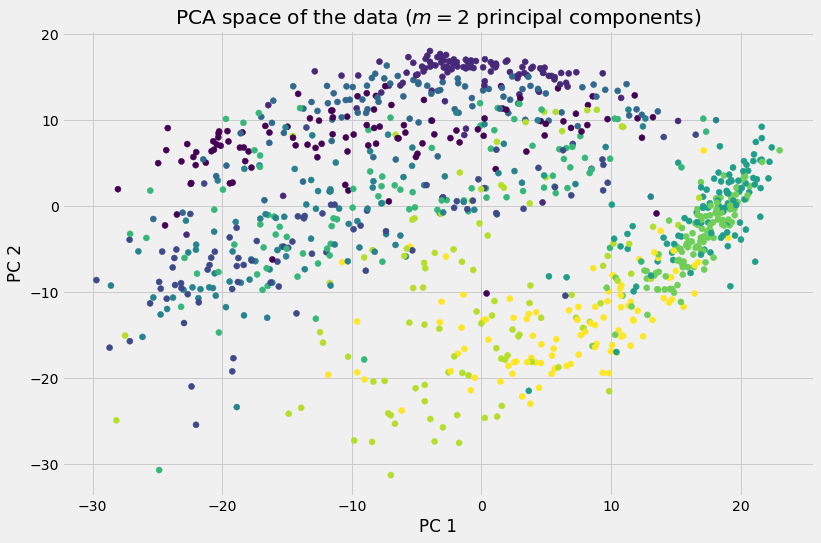

In [22]:
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=targets)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA space of the data 'r'$(m = 2$'' principal components)')

We can see that the PCA representation of the data using the first $m = 2$ principal components is quite powerful in this case. Specifically, when we project onto this $2$-dimensional space, we can see some clustering (to some degree) of the data based on the class label (i.e. the different colors corresponding to different class labels are somewhat separable in this $2$-dimensional space; only a few classes overlap and would be indistinguishable without the coloring). This is quite remarkable given that in this representation, the data is characterized by only $2$ features, as opposed to the $784$ features (corresponding to pixel values) in the original data set.

We will now consider the data points as described by these $m = 2$ principal components of PCA and apply a $k$-means clustering algorithm to them. The $k$-means clustering algorithm can be summarized as

1. Given a number of clusters $k$, assign each point to one of the clusters at random;
2. Compute the centroid of each of the $k$ clusters as
$$\mathbf{m}_l = \frac{1}{|c_l|} \sum_{i \in c_l} \mathbf{x}^{(i)} \text{ for } l = 1, ..., k \text{;}$$
3. Reassign $x^{(i)}$ to the closest centroid, i.e.
$$l_i^{(t+1)} = \text{argmin}_{l} \| \mathbf{x}^{(i)} - \mathbf{m}_l \|^2$$

where $l_i^{(t)}$ denotes the cluster assigned to $\mathbf{x}^{(i)}$ at iteration $t$.

We will iterate steps $1$ and $2$ until convergence (i.e. the assignments do not change from one iteration to the next one).

In [23]:
def k_means(X, k, max_iters=50):
    np.random.seed(42)
    
    n_samples, n_features = X.shape
    
    # assign each point to one cluster at random
    labels = np.random.randint(low=0, high=k, size=n_samples).reshape(-1, 1)
    # append the assignments to the data matrix
    X_labels = np.hstack([X, labels])
    
    # compute centroids of the clusters for the random assignment
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1] == i], axis=0)[0:2]
        
    new_labels = np.zeros(n_samples)
    
    # at each iteration...
    for i in range(max_iters):
        
        #... compute the distance from each point to each centroid
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        #... compute potential reassignment (each point gets reassigned to the closest centroid)
        new_labels = np.argmin(distances, axis=0)
        
        # if assignments remain unchanged...
        if (labels == new_labels).all():
            #... terminate algorithm
            break
            
        # otherwise...
        else:
            
            #... reassign points to the closest centroid
            labels = new_labels
            
            #... compute new centroids
            for c in range(k):
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    
    return centroids, labels

Given a clustering $\mathcal{C} = \{ c_l \}_{l=1}^k$ obtained through $k$-means clustering, we can rewrite the objective function (total within-cluster distance) as
$$W(\mathcal{C}, k) = \sum_{l=1}^k \sum_{i \in c_l} \| \mathbf{x}^{(i)} - \mathbf{m}_l \|^2$$

where $\mathbf{m}_l$ is defined as before.

In [24]:
def within_distance(X, labels, centroids):

    # initialise loss function W
    W = 0
    
    # iterate through clusters
    for j in range(len(centroids)):
        
        c = centroids[j]
        
        # iterate through points
        for i in range(len(X)):
            # if point is in current cluster
            if labels[i] == j:
                # add distance from point to centroid to W
                W += np.linalg.norm(X[i, :] - c) ** 2
                
    return W

We will now vary $k$ in the $k$-means clustering algorithm from $k=2$ to $k=10$ and compute the loss function $W(\mathcal{C}, k)$ for each clustering to obtain the optimal value for $k$.

In [25]:
W_vec = []

for k in range(2, 11):
    centroids, labels = k_means(X_pca, k)
    W = within_distance(X_pca, labels, centroids)
    W_vec.append(W)

Text(0.5,1,'Within-cluster distance for varying number of clusters $k$')

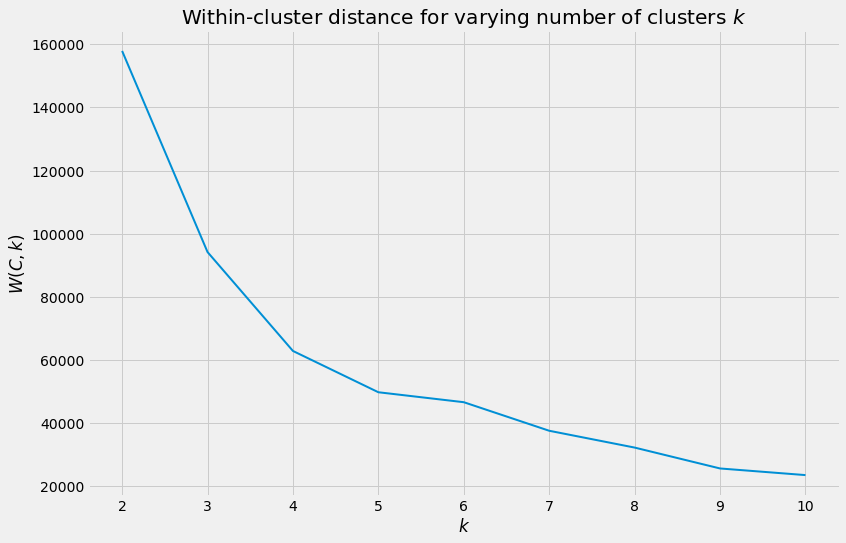

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(2, 11), W_vec, linewidth=2)
plt.xlabel(r'$k$')
plt.ylabel(r'$W(C, k)$')
plt.title('Within-cluster distance for varying number of clusters 'r'$k$')

Naturally, we can see that as the number of clusters $k$ is increased, the within-cluster distance $W(\mathcal{C}, k)$ decreases. Ideally, we want to find the smallest $k$ that produces a small $W(\mathcal{C}, k)$ in order to provide a concise description of the data set through the $k$ clusters. To do this, we can look for the "elbow" of the curve i.e. the point where increasing $k$ further brings no further improvement. In our case, this phenomenon can be observed around $k = 4$ or $k = 5$: for the initial values of $k$, there is a drastic improvement in $W(\mathcal{C}, k)$ when the number of clusters is increased, but after $k = 5$, minimal gains can be observed. Hence, a sensible choice of $k$ would be either $4$ or $5$, which, somewhat surprisingly is different from the true number of classes in the data set ($10$). This can be explained by the fact that the data has been reduced to its $2$-dimensional PCA space (a fair amount of information is lost; as we saw from the visual representation there are some classes that overlap). Additionaly, as highlighted before, choosing $k$ is a conservative process (we try to achieve maximum information with minimal a $k$) which might also explain the deviation from our a priori knowledge.

Lastly, we will look at how the five clusters obtained from $k$-means clustering compare to the true classes in the data set (and also where the centroids of the former clusters lay in the $2$-dimensional PCA space of the data):

In [27]:
centroids, labels = k_means(X_pca, 5)

Text(0.5,1,'$k$-means clustering labels')

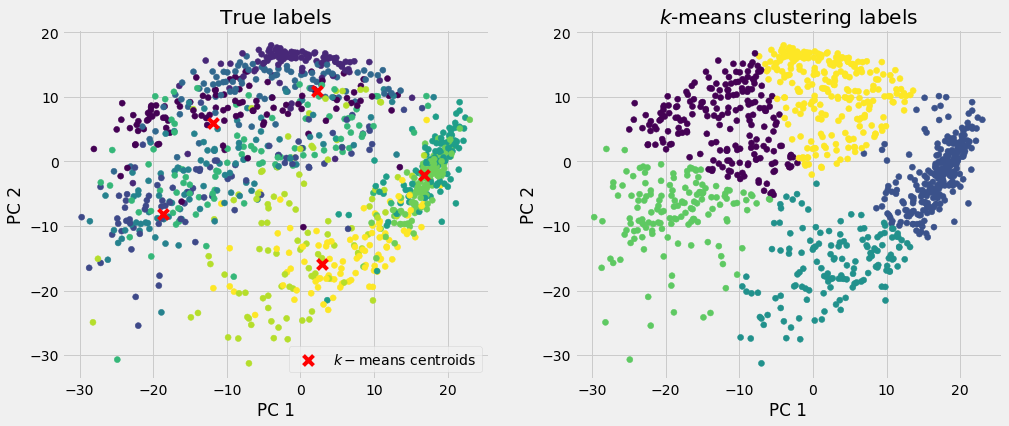

In [28]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=targets)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label=r'$k-$''means centroids')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title('True labels')
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title(r'$k$''-means clustering labels')

## 2.2 Clustering of the feature matrix {-}

We will now work with another data set from a social network of bottlenose dolphins that was originally collected in a study of the social behaviour and interactions of a group of $62$ bottlenose dolphins. Each row of the data set corresponds to one of the $N = 62$ bottlenose dolphins in the studied network and there are two sources of information:

1. A set of features characterising each individual that is given as a $N \times p$ matrix $F$ (where $N = 62$ is the number of samples and $p = 32$ is the number of features;
2. The social network of associations between the individual dolphins that is given as a $N \times N$ adjacency matrix $A$ (where again $N = 62$ is the number of samples and the $E = 159$ edges correspond to frequent interactions between dolphins).

First, we will employ hierarchical clustering to cluster the feature matrix $F$.

In [29]:
F = np.load('dolphins_F_62x32(1).npy')

We will use the Euclidian distance as our distance measure between samples:

In [30]:
def pairwise_distances(points):
    
    N, D = points.shape
    distance = np.empty((N, N))
    
    # iterate through the samples
    for i in range(N):
        
        # set d(i, i) = 0
        distance[i, i] = 0
        
        # iterate through all other points (minding the symmetry of the distance matrix)
        for j in range(i + 1, N):
            
            # compute distance
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())
            # append it to distance matrix
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

In [31]:
d = pairwise_distances(F)

We will use average linkage for the hierarchical clustering i.e.
$$d_{GA}(G, H) = \frac{1}{N_G N_H} \sum_{i \in G, j \in H} d(i, j)$$

In [32]:
def average_linkage(distances, cluster_assignment, i, j):

    # select the point indices of the two clusters
    points_i = np.argwhere(cluster_assignment == i)
    points_j = np.argwhere(cluster_assignment == j)
    
    # form a cartesian product between the indices in i and indices in j
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])

    # select the pair distances between the points in the two clusters from the distances matrix
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]

    # return the average
    return pairs_distance.mean()

In [33]:
def hierarchical_clustering(points, distances):

    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # the id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # begin from level (N - 1) to level 1
    for level in range(N-1, 0, -1):

        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # initialize the cluster ids to be merged in this iteration
        cluster_a, cluster_b = (-1, -1) 
        
        # find the two clusters that have the minimum distance in between
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):

                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]

                d = average_linkage(distances, current_assignment, cluster_i, cluster_j)

                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1

        # store the current cluster assignment into the assignments array
        assignments[level, :] = current_assignment
        
    return assignments

Computing the hierarchical clustering:

In [34]:
assignments = hierarchical_clustering(F, d)

We will now compute the Silhouette score for each of the $62$ clusterings obtained using hierarchical clustering. First, for a data point $i \in C_I$ (data point $i$ in the cluster $C_I$) let
$$a(i) = \frac{1}{|C_I| - 1} \sum_{j \in C_I, j \neq i} d(i, j)$$

be the mean distance between $i$ and all other points in the same cluster $C_I$ (here $|C_I|$ denoted the number of points in the cluster; we divide by $|C_I| - 1$ because we do not include $d(i, i)$ in the sum).

In [38]:
def mean_cluster_distance(points, distances, assignments):
    N, D = points.shape
    
    a = np.zeros(N)
    
    # compute the cardinality of each cluster
    cardinality = dict((x, list(assignments).count(x)) for x in set(assignments))
    
    # iterate through all points i
    for i in range(N):
        
        # get C_I (the cluster of the current point)
        curr_cluster = assignments[i]
        
        # iterate through all other points j
        for j in range(N):
            
            # if j is in C_I and j is not equal to i
            if assignments[j] == curr_cluster and i != j:
                
                # add d(i, j) to a(i)
                a[i] += distances[i, j]
        
        # if cluster is not a singleton (to avoid division by zero)
        if cardinality[curr_cluster] > 1:
            
            # divide a(i) by |C_I| - 1
            a[i] /= (cardinality[curr_cluster] - 1)

        # otherwise
        else:
            
            # set a(i) to -1
            a[i] = -1
    
    return a

Next, for each data point $i \in C_I$ let
$$b(i) = \min_{J \neq I} \frac{1}{|C_J|} \sum_{j \in C_J} d(i, j)$$

be the minimum mean distance of $i$ to the points in any other cluster $C_J$ different from $C_I$.

In [39]:
def min_dissimilarity(points, distances, assignments):
    N, D = points.shape
    
    b = np.zeros(N)
    
    # compute cardinality of each cluster
    cardinality = dict((x, list(assignments).count(x)) for x in set(assignments))
      
    # iterate through all points i
    for i in range(N):
        
        # get C_I (the cluster of current point)
        curr_cluster = assignments[i]
        
        # intitialize minimum mean distance
        min_diss = np.inf
        
        # iterate through all clusters
        for cluster in set(assignments):
            
            # for all clusters other than C_I
            if cluster != curr_cluster:
                
                # initialize mean distance
                diss = 0
                
                # iterate through all other points j
                for j in range(N):
                    
                    # if j is is C_J
                    if assignments[j] == cluster:
                        
                        # add d(i, j) to mean distance
                        diss += distances[i, j]
                        
                # divide by |C_J|
                diss /= cardinality[cluster]
                
                # update minimum mean distance
                if diss < min_diss:
                    min_diss = diss
                    
        # assign b(i) to i
        b[i] = min_diss
        
    return b

Lastly, we can use the quantities defined above to define the silhouette score for a point $i$ as
$$s(i) = \frac{b(i) - a(i)}{\max \{ a(i), b(i) \}} \text{ if } |C_I| > 1$$

and $s(i) = 0$ otherwise (in our case if $a(i) = -1$).

In [40]:
def silhouette_coef(a, b):
    N = len(a)
    
    s = np.zeros(N)
    
    # iterate through all points i
    for i in range(N):
        
        # if |C_I| > 1 (a(i) not -1)
        if a[i] != -1:
            
            # compute s(i) using formula above
            s[i] = (b[i] - a[i]) / max(a[i], b[i])
            
        # otherwise
        else:
            
            # set s(i) to 0
            s[i] = 0
        
    return s

The Silhouette score of a cluster is defined as the average of the silhouette scores of the points in that cluster. We will now compute the silhouette score for the clusterings obtained from hierarchical clustering (to determine the optimal level i.e. the level that maximizes this score):

In [41]:
scores = []

for n_c in range(2, 61):
    a = mean_cluster_distance(F, d, assignments[n_c, :])
    b = min_dissimilarity(F, d, assignments[n_c, :])
    s = silhouette_coef(a, b)
    scores.append(s.mean())

Text(0.5,1,'Silhouette score for the clusters obtained from hierarchical clustering')

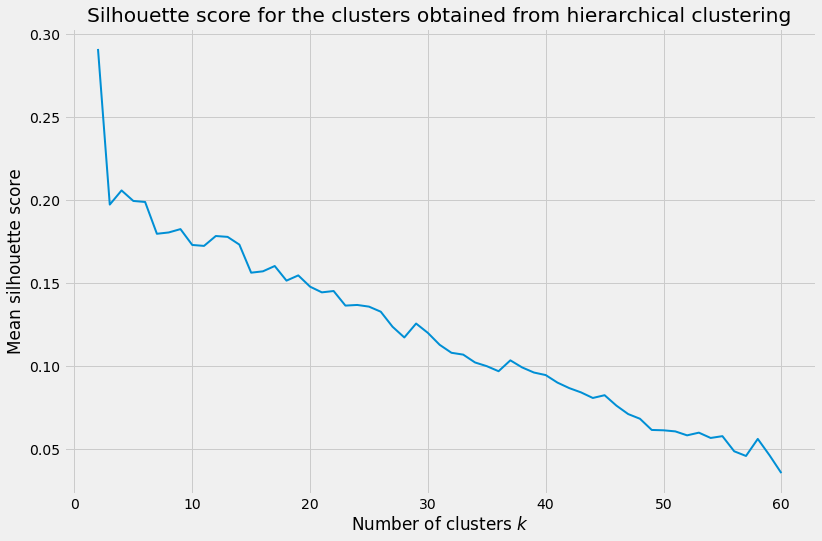

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(2, 61), scores, linewidth=2)
plt.xlabel('Number of clusters 'r'$k$')
plt.ylabel('Mean silhouette score')
plt.title('Silhouette score for the clusters obtained from hierarchical clustering')

We can see that the optimal value of the silhouette score is obtained for $k = 2$ clusters (i.e. the coarsest clustering obtained from hierarchical clustering). We can see that this maximum is achieved by quite some margin (i.e. there is a significant drop in the silhouette score for $k = 3$ and onward) and the value of the silhouette score (approximately $0.3$) suggests that the data is fairly well clustered (we have that $-1 \leq s(i) \leq 1$ for all $i$ and $s(i) = 1$ indicates that a point $i$ is well clustered).

## 2.3 Graph-based analysis {-}

In this last part, we will analyse the dolphin social network i.e. the graph of frequent associations encoded by adjacency matrix $A$.

First, we will obtain the spectral partition of the graph based on the normalized Laplacian of the dolphin network.

In [9]:
A = np.load('dolphins_A_62x62(1).npy')

For a graph $G$ with adjacency matrix $A$ and degree matrix $D$, the normalized Laplacian is defined as
$$L = I - AD^{-1} = (D - A)D^{-1} \text{.}$$

In [10]:
def normalized_laplacian(A):
    degrees = A.sum(axis=1)
    D = np.diag(degrees)
    L = D - A
    return L @ np.linalg.inv(D)

Computing the normalized Laplacian $L$:

In [11]:
L = normalized_laplacian(A)

Computing the first two eigenvalues of $L$ (smallest magnitude) and their corresponding eigenvectors:

In [12]:
l, v = np.linalg.eig(L)

sorted_ind = np.argsort(l)[:2]
l = l[sorted_ind]
v = v[:, sorted_ind]

In [13]:
print('First eigenvalue of L: {}'.format(l[0]))
print('Second eigenvalue of L: {}'.format(l[1]))

First eigenvalue of L: 5.551115123125783e-17
Second eigenvalue of L: 0.03952455375743434


As expected (and as derived in the lecture notes), we can see that the smallest eigenvalue of $L$ is $\lambda_1 = 0$ (and note also that this is the only zero eigenvalue since the graph is connected). We will now use the second eigenvalue to obtain the spectral partition of the graph.

As we have seen in the lecture notes, for the relaxation of the partition problem with cost function
$$C(\mathbf{s}, \lambda, \mu) = \mathbf{s}^T L \mathbf{s} + \lambda (N - \mathbf{s}^T \mathbf{s}) + 2\mu \Big( (n_1 - n_2) - \mathbf{s}^T \mathbf{1} \Big)$$

where $\mathbf{s} \in \mathbb{R}^N, \lambda \in \mathbb{R}, \mu \in \mathbb{R}$, the lowest value of $C$ is achieved for the second eigenvalector $\mathbf{v}_2$ of $L$ (corresponding to the second i.e. first non-trivial eigenvalue $\lambda_2$ of $L$):

$$C_\text{min} = \lambda_2 \frac{n_1 n_2}{N} \text{.}$$

Since the size of the split (i.e. $n_1$ and $n_2$) is not given, the spectral partition can be obtained by assigning all elements with $\mathbf{v}^{(i)} < 0$ to the first cluster and all elements with $\mathbf{v}^{(i)} > 0$ to the second cluster.

In [14]:
s = np.sign(v[:, 1])

Visualising the spectral partition of the graph:

Text(0.5,1,'Spectral partition of graph')

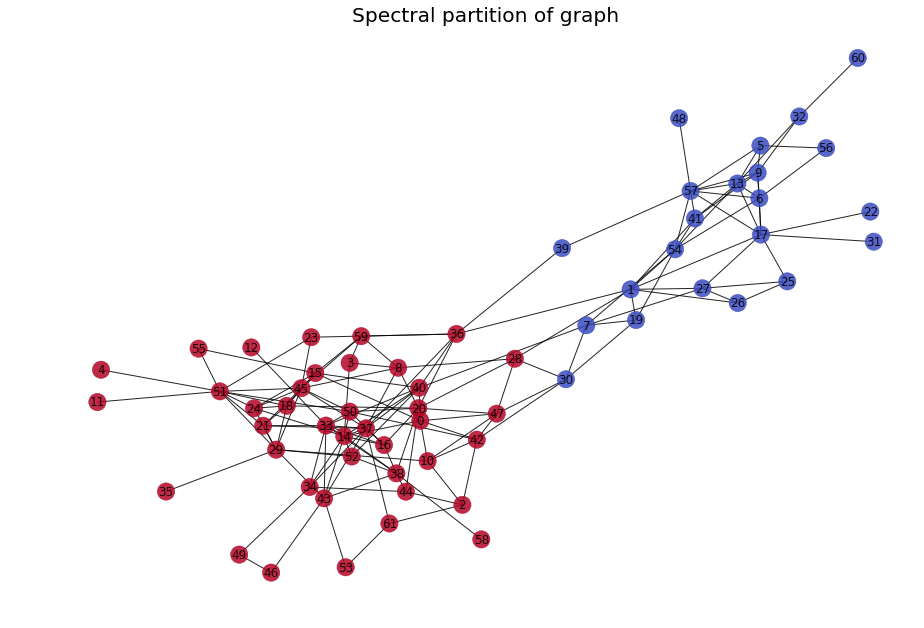

In [15]:
np.random.seed(42)

G = nx.Graph(A)

plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color=s, cmap=plt.cm.get_cmap('coolwarm'), alpha=0.85)
plt.title('Spectral partition of graph')

Lastly, we will compute three different centrality measures for the nodes in the graph: degree, eigenvector and PageRank.

The degree centrality is defined as
$$\mathbf{c}_d = \frac{\mathbf{d}}{2E} = \frac{A \mathbf{1}}{2E} \text{.}$$

In [22]:
def degree_centrality(A):
    degrees = A.sum(axis=1)
    c = degrees / A.sum()
    return c

In [23]:
d_c = degree_centrality(A)

In [24]:
print(d_c)

[0.01886792 0.02515723 0.01257862 0.00943396 0.00314465 0.01257862
 0.01886792 0.01572327 0.01886792 0.02201258 0.01572327 0.00314465
 0.00314465 0.02515723 0.03773585 0.02201258 0.01886792 0.02830189
 0.02201258 0.01257862 0.02830189 0.01886792 0.00314465 0.00943396
 0.01886792 0.00943396 0.00943396 0.01572327 0.01572327 0.02830189
 0.01572327 0.00314465 0.00943396 0.03144654 0.01572327 0.00314465
 0.02201258 0.03459119 0.02515723 0.00628931 0.02515723 0.01572327
 0.01886792 0.02201258 0.01257862 0.03459119 0.00628931 0.01886792
 0.00314465 0.00628931 0.02201258 0.03144654 0.01257862 0.00628931
 0.02201258 0.00628931 0.00628931 0.02830189 0.00314465 0.01572327
 0.00314465 0.00943396]


In [26]:
print(np.argsort(d_c)[::-1])

[14 45 37 33 51 17 57 29 20 13 38 40  1 18  9 36 15 54 43 50 21 24  0 42
 16 47  8  6 10  7 27 28 30 41 59 34 19 52  5 44  2  3 61 23 32 25 26 39
 46 49 53 55 56 58  4 60 11 12 31 35 22 48]


We can see that according to the degree centrality, Grin, Topless and SN4 are highly central.

The eigenvector centrality is defined as the leading eigenvector of the adjacency matrix i.e.
$$A \mathbf{c}_e = \lambda_N \mathbf{c}_e \text{.}$$

In [27]:
def eigenvalue_centrality(A):
    e, v = np.linalg.eig(A)
    ind = np.argmax(e)
    c = v[:, ind]
    return c

In [28]:
d_e = eigenvalue_centrality(A)

In [29]:
print(d_e)

[0.12850353 0.04207615 0.03975712 0.07933476 0.02928739 0.00655926
 0.01219126 0.04290099 0.14310214 0.01219738 0.07525347 0.02928739
 0.03907614 0.01500469 0.31578285 0.16417581 0.20799426 0.01751244
 0.20249469 0.02067478 0.18447739 0.2073514  0.00243444 0.08736214
 0.19321357 0.00594605 0.00894396 0.01631719 0.0682235  0.21176308
 0.04074725 0.00243444 0.00385593 0.28109869 0.13882809 0.02943765
 0.1327621  0.30056205 0.19661764 0.02087104 0.20787191 0.01524357
 0.0809501  0.19033934 0.07780237 0.28500522 0.02971651 0.08037062
 0.00241549 0.02342975 0.21769179 0.21068221 0.12956429 0.03368693
 0.02300201 0.05210983 0.00260655 0.01737613 0.02733225 0.11181862
 0.00053602 0.0519914 ]


In [30]:
print(np.argsort(d_e)[::-1])

[14 37 45 33 50 29 51 16 40 21 18 38 24 43 20 15  8 34 36 52  0 59 23 42
 47  3 44 10 28 55 61  7  1 30  2 12 53 46 35  4 11 58 49 54 39 19 17 57
 27 41 13  9  6 26  5 25 32 56 31 22 48 60]


We can see that according to the eigenvalue centrality, Grin, SN4 and Topless are highly central.

The PageRank centrality can be obtained through the following iterative scheme
$$\mathbf{c}_{PR}^{(t+1)} = \alpha (AD^{-1}) \mathbf{c}_{PR}^{(t)} + (1 - \alpha) \frac{1}{N} \mathbf{1}$$

for $\alpha \in [0, 1]$ (customarily set to $\alpha = 0.85$).

In [31]:
def pagerank_centrality(A, alpha=0.85, num_iters=250):
    degrees = A.sum(axis=1)
    N = len(degrees)
    D = np.diag(degrees)
    W = A @ np.linalg.inv(D)
    
    c = ((1 - alpha) / N) * np.ones((N, 1))
    
    for _ in range(num_iters):
        c = alpha * W @ c + ((1 - alpha) / N)
        
    return c.reshape(1, -1)

In [34]:
d_pr = pagerank_centrality(A)[0]

In [35]:
print(d_pr)

[0.01696539 0.02465072 0.01333808 0.00962906 0.0050798  0.01442805
 0.02005363 0.01564303 0.0170983  0.02345848 0.0151084  0.0050798
 0.00483532 0.02615688 0.03214449 0.01988308 0.01662682 0.03172814
 0.01939555 0.0129282  0.02464092 0.01693899 0.0054159  0.0098635
 0.01690576 0.01150422 0.01121014 0.01713009 0.01484574 0.02645855
 0.0153021  0.0054159  0.01330868 0.02842307 0.01591994 0.00491822
 0.02061339 0.02987534 0.02393924 0.00776475 0.02196637 0.01613757
 0.01761865 0.02169113 0.01283083 0.0295142  0.0088259  0.01733952
 0.0052617  0.00887675 0.01923194 0.03129936 0.01207259 0.00818105
 0.02165088 0.00749417 0.00832625 0.03009537 0.0049629  0.01476792
 0.00619015 0.01103919]


In [36]:
print(np.argsort(d_pr)[::-1])

[14 17 51 57 37 45 33 29 13  1 20 38  9 40 43 54 36  6 15 18 50 42 47 27
  8  0 21 24 16 41 34  7 30 10 28 59  5  2 32 19 44 52 25 26 61 23  3 49
 46 56 53 39 55 60 22 31 48 11  4 58 35 12]


According to the PageRank centrality, Grin, Jet and Trigger are highly central. 

Hence, we can see that Grin appears to be the most central bottlenose dolphin (highest centrality for three different measures) based on our calculations. However, Grin is not mentioned in the study as being one of the most central dolphins.